# Exploratory Data Analysis for AI for Agriculture 2026

> Reference: <br>
> [[1]Data paper](../references/data_paper.pdf)<br>
> [[2]Slide_paper_present_sample](../references/slide_paper_present_sample.pdf)<br>
> [[3]EDA](../references/ML03_EDA.pdf)

<figure align="center">
    <img src="../EDA_question_and_details.png" alt="EDA question and details" width="700"/>
</figure>

Overview about the dataset:
- How authors collect data?
- 3 types of data: 
    + RGB, 
    + MS: multi-spectral, 
    + HS: hyper-spectral 
- What is characteristics of each data type?
- ...

## 1. RGB

Thống kê kích cỡ ảnh? Có bao nhiêu ảnh? Mỗi ảnh kích cỡ chiều rộng, chiều cao bao nhiêu?
Có ảnh nào đặc biệt không?
Quan sát, đưa 10 ảnh cho mỗi loại?
...

In [1]:
import cv2 
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter, defaultdict
from PIL import Image
import tifffile as tiff
import pandas as pd
from IPython.display import display
from PIL import ImageFile

In [2]:
RGB_DIR=r'D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB'

In [3]:
def lay_nhan(fname:str)->str:
    return os.path.basename(fname).split("_")[0]

In [4]:
files=[f for f in os.listdir(RGB_DIR)  if f.lower().endswith(".png")]
class_counts=Counter(lay_nhan(f) for f in files)
print(f"Total images: {len(files)}")
print(f"Classes: {dict(class_counts)}")

Total images: 600
Classes: {'Health': 200, 'Other': 200, 'Rust': 200}


tổng số ảnh của mỗi loại bằng nhau (600 ảnh)/ 1 loại


In [5]:
sizes = []
for f in files:
    with Image.open(os.path.join(RGB_DIR, f)) as img:
        sizes.append(img.size) # Trả về (width, height)

# Thống kê các loại kích cỡ xuất hiện
size_counts = Counter(sizes)
print(f"Các loại kích cỡ ảnh (Width, Height): {dict(size_counts)}")

# Kiểm tra xem có ảnh nào khác biệt (outlier) không
unique_sizes = list(size_counts.keys())
if len(unique_sizes) == 1:
    print(f"Tất cả ảnh đều đồng nhất kích thước: {unique_sizes[0]}")
else:
    print(f"Cảnh báo: Có {len(unique_sizes)} loại kích thước khác nhau!")

Các loại kích cỡ ảnh (Width, Height): {(64, 64): 600}
Tất cả ảnh đều đồng nhất kích thước: (64, 64)


In [6]:
import os, glob
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display

# 2) scan_dir tối giản cho RGB (đủ H,W,C,fname)
def scan_dir(img_dir, limit=None):
    files = []
    for ext in ("*.png", "*.jpg", "*.jpeg"):
        files += glob.glob(os.path.join(img_dir, "**", ext), recursive=True)
    files = sorted(files)
    if limit is not None:
        files = files[:limit]

    rows = []
    for p in files:
        try:
            with Image.open(p) as im:
                w, h = im.size
                mode = im.mode  # "RGB", "RGBA", "L", ...
            c = 3 if mode in ["RGB", "RGBA"] else (1 if mode == "L" else None)
            rows.append({
                "path": p,
                "fname": os.path.basename(p),
                "H": h, "W": w, "C": c,
                "mode": mode,
                "ext": os.path.splitext(p)[1].lower(),
            })
        except Exception as e:
            rows.append({
                "path": p,
                "fname": os.path.basename(p),
                "H": None, "W": None, "C": None,
                "mode": None,
                "ext": os.path.splitext(p)[1].lower(),
                "error": type(e).__name__,
            })

    return pd.DataFrame(rows)

# 3) scan_dir_enhanced
def scan_dir_enhanced(img_dir, limit=None):
    df = scan_dir(img_dir, limit=limit)

    # class theo tên file: Health_..., Rust_..., Other_...
    df["class"] = df["fname"].astype(str).apply(lambda x: x.split("_")[0])

    # aspect ratio: tránh chia cho 0/None
    df["aspect_ratio"] = np.where(
        (df["H"].notna()) & (df["H"] != 0),
        df["W"] / df["H"],
        np.nan
    )
    return df

# 4) Chạy
df = scan_dir_enhanced(RGB_DIR, limit=600)

# 5) Hiển thị đẹp
styled_df = (
    df.sample(min(10, len(df)), random_state=42)
      .style
      .background_gradient(subset=["H", "W", "C"], cmap="viridis")
      .set_caption("Sample of Image Metadata (RGB)")
)
display(styled_df)

print("Counts by class:")
display(df["class"].value_counts())


,path,fname,H,W,C,mode,ext,class,aspect_ratio
110,D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Health_hyper_199.png,Health_hyper_199.png,64,64,3,RGB,.png,Health,1.000000
419,D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Rust_hyper_116.png,Rust_hyper_116.png,64,64,3,RGB,.png,Rust,1.000000
565,D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Rust_hyper_68.png,Rust_hyper_68.png,64,64,3,RGB,.png,Rust,1.000000
77,D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Health_hyper_169.png,Health_hyper_169.png,64,64,3,RGB,.png,Health,1.000000
181,D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Health_hyper_82.png,Health_hyper_82.png,64,64,3,RGB,.png,Health,1.000000
284,D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Other_hyper_175.png,Other_hyper_175.png,64,64,3,RGB,.png,Other,1.000000
10,D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Health_hyper_108.png,Health_hyper_108.png,64,64,3,RGB,.png,Health,1.000000
469,D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Rust_hyper_161.png,Rust_hyper_161.png,64,64,3,RGB,.png,Rust,1.000000
78,D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Health_hyper_17.png,Health_hyper_17.png,64,64,3,RGB,.png,Health,1.000000
349,D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Other_hyper_53.png,Other_hyper_53.png,64,64,3,RGB,.png,Other,1.000000


Counts by class:


class
Health    200
Other     200
Rust      200
Name: count, dtype: int64

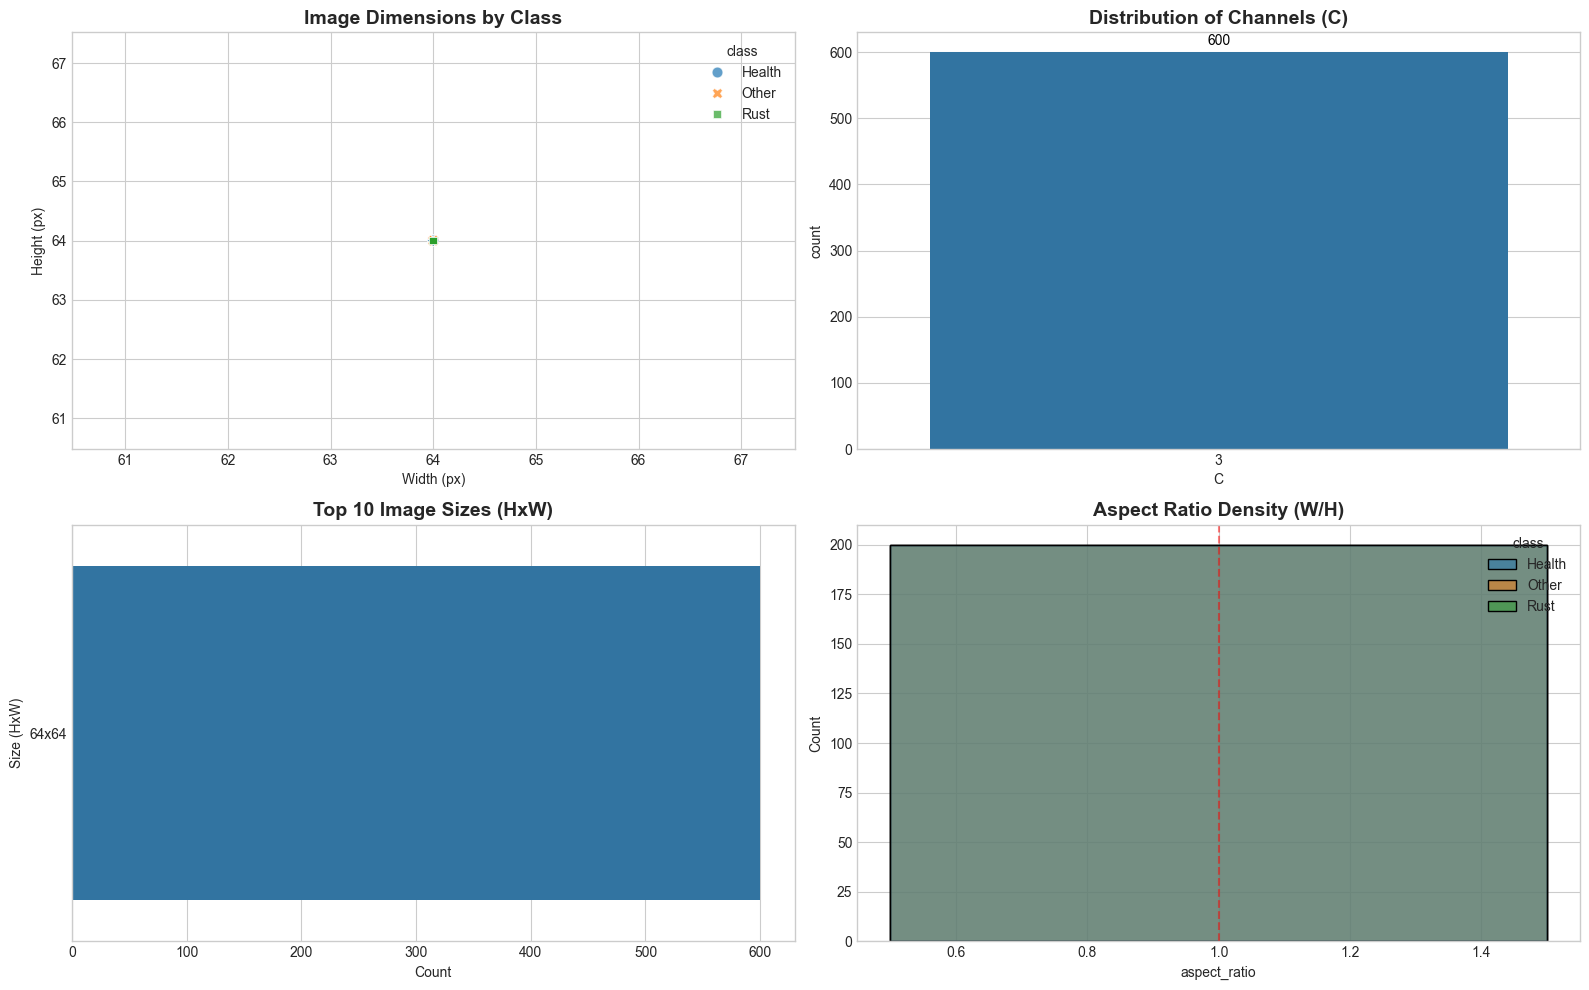

In [7]:
import seaborn as sns

# đảm bảo có cột size_hw (nếu chưa có)
if "size_hw" not in df.columns:
    df["size_hw"] = df.apply(
        lambda r: f'{int(r["H"])}x{int(r["W"])}' if pd.notna(r["H"]) and pd.notna(r["W"]) else "NA",
        axis=1
    )

# lọc data hợp lệ cho từng plot
df_wh = df.dropna(subset=["W", "H", "class"]).copy()
df_wh["W"] = df_wh["W"].astype(float)
df_wh["H"] = df_wh["H"].astype(float)

df_ar = df.dropna(subset=["aspect_ratio", "class"]).copy()
# loại inf (phòng khi H=0)
df_ar = df_ar[np.isfinite(df_ar["aspect_ratio"])]

plt.style.use("seaborn-v0_8-whitegrid")
fig = plt.figure(figsize=(16, 10))

# --- 1) Scatter W vs H ---
ax1 = plt.subplot(2, 2, 1)
sns.scatterplot(
    data=df_wh, x="W", y="H",
    hue="class", style="class",
    s=60, alpha=0.7, ax=ax1
)
ax1.set_title("Image Dimensions by Class", fontsize=14, fontweight="bold")
ax1.set_xlabel("Width (px)")
ax1.set_ylabel("Height (px)")

# --- 2) Countplot Channels ---
ax2 = plt.subplot(2, 2, 2)
df_c = df.dropna(subset=["C"]).copy()
sns.countplot(data=df_c, x="C", ax=ax2, color=None)  # tránh warning palette/hue
ax2.set_title("Distribution of Channels (C)", fontsize=14, fontweight="bold")
for p in ax2.patches:
    ax2.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center', va='baseline',
        fontsize=10, color='black',
        xytext=(0, 5), textcoords='offset points'
    )

# --- 3) Top size combos ---
ax3 = plt.subplot(2, 2, 3)
top_sizes = df["size_hw"].value_counts().head(10)
sns.barplot(x=top_sizes.values, y=top_sizes.index, ax=ax3)
ax3.set_title("Top 10 Image Sizes (HxW)", fontsize=14, fontweight="bold")
ax3.set_xlabel("Count")
ax3.set_ylabel("Size (HxW)")

# --- 4) KDE Aspect Ratio ---
ax4 = plt.subplot(2, 2, 4)
if len(df_ar) >= 2 and df_ar["aspect_ratio"].nunique() > 1:
    sns.kdeplot(
        data=df_ar, x="aspect_ratio",
        hue="class", fill=True,
        common_norm=False, ax=ax4
    )
else:
    # nếu dữ liệu ít hoặc chỉ 1 giá trị -> KDE không có ý nghĩa
    sns.histplot(data=df_ar, x="aspect_ratio", hue="class", kde=False, ax=ax4)
ax4.set_title("Aspect Ratio Density (W/H)", fontsize=14, fontweight="bold")
ax4.axvline(1.0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


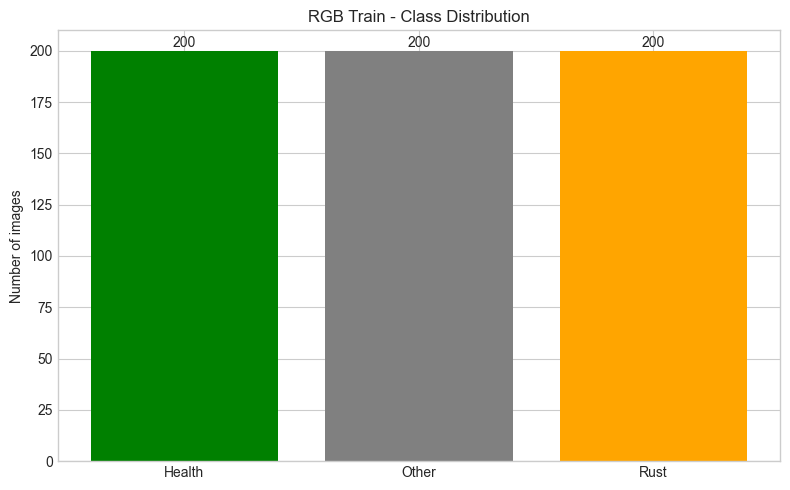

In [8]:
# Plot distribution
plt.figure(figsize=(8, 5))
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]
plt.bar(classes, counts, color=['green', 'gray', 'orange'])
plt.ylabel('Number of images')
plt.title('RGB Train - Class Distribution')
for i, v in enumerate(counts):
    plt.text(i, v + 2, str(v), ha='center')
plt.tight_layout()
plt.show()

In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = False  # để ảnh truncated bị báo lỗi rõ ràng

def quality_check_rgb(path, thumb=64,
                      black_mean_thr=8,       # mean grayscale thấp -> ảnh rất tối
                      black_ratio_thr=0.98,   # % pixel <= 10 quá cao -> gần như đen
                      low_std_thr=6,          # std thấp -> gần như 1 màu (mất tương phản)
                      white_ratio_thr=0.98):  # % pixel >= 245 quá cao -> gần như trắng

    row = {"path": path, "status": "ok", "reason": ""}

    # 1) Check corrupt
    try:
        with Image.open(path) as im:
            im.verify()  # chỉ verify header, không load full
    except Exception as e:
        row["status"] = "corrupt"
        row["reason"] = f"verify_fail: {type(e).__name__}"
        return row

    # 2) Load để tính stats
    try:
        with Image.open(path) as im:
            im = im.convert("RGB")
            row["W"], row["H"] = im.size

            # thumbnail để nhanh
            im_small = im.resize((thumb, thumb))
            arr = np.asarray(im_small).astype(np.float32)  # (thumb,thumb,3)
    except Exception as e:
        row["status"] = "corrupt"
        row["reason"] = f"load_fail: {type(e).__name__}"
        return row

    # grayscale approx
    gray = 0.299*arr[...,0] + 0.587*arr[...,1] + 0.114*arr[...,2]

    mean = float(gray.mean())
    std  = float(gray.std())
    black_ratio = float((gray <= 10).mean())
    white_ratio = float((gray >= 245).mean())

    row.update({
        "mean_gray": mean,
        "std_gray": std,
        "black_ratio": black_ratio,
        "white_ratio": white_ratio,
    })

    flags = []
    if mean < black_mean_thr and black_ratio > black_ratio_thr:
        flags.append("near_black")
    if white_ratio > white_ratio_thr:
        flags.append("near_white")
    if std < low_std_thr:
        flags.append("low_contrast")

    if flags:
        row["status"] = "flagged"
        row["reason"] = ",".join(flags)

    return row

# ====== CHỈNH PATH FOLDER RGB ======
RGB_DIR = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB" 

files = sorted(glob.glob(os.path.join(RGB_DIR, "**/*.png"), recursive=True))
# nếu jpg thì thêm:
files += sorted(glob.glob(os.path.join(RGB_DIR, "**/*.jpg"), recursive=True))
files += sorted(glob.glob(os.path.join(RGB_DIR, "**/*.jpeg"), recursive=True))

print(f"🔍 Scanning {len(files)} images...")
rows = [quality_check_rgb(p) for p in files]
df = pd.DataFrame(rows)

# ========= THỐNG KÊ TỔNG QUAN =========
print("\n" + "=" * 100)
print("📊 OVERALL QUALITY REPORT")
print("=" * 100)
print(df["status"].value_counts())

# ========= IN RA TẤT CẢ ẢNH BỊ FLAGGED (KHÔNG LIMIT) =========
df_flagged = df[df["status"] != "ok"].copy()

if len(df_flagged) > 0:
    print("\n" + "=" * 100)
    print(f"🚨 DETAILED FLAGGED IMAGES REPORT ({len(df_flagged)} images)")
    print("=" * 100)
    
    # Thêm cột filename để dễ đọc hơn
    df_flagged['filename'] = df_flagged['path'].apply(lambda x: os.path.basename(x))
    
    # Thêm cột class từ filename
    df_flagged['class'] = df_flagged['filename'].apply(lambda x: x.split('_')[0])
    
    # Sắp xếp theo class và reason để dễ phân tích
    df_flagged = df_flagged.sort_values(['class', 'reason', 'filename'])
    
    # Cấu hình pandas để hiển thị FULL (không truncate)
    pd.set_option('display.max_rows', None)  # ⬅️ QUAN TRỌNG: Hiện tất cả rows
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    
    # In ra bảng đầy đủ với format đẹp
    print("\n📋 FULL LIST OF FLAGGED IMAGES:")
    print("-" * 100)
    
    display_cols = ['filename', 'class', 'status', 'reason', 'mean_gray', 'std_gray', 
                   'black_ratio', 'white_ratio', 'W', 'H']
    
    # Style cho dễ đọc
    styled_df = (
        df_flagged[display_cols]
        .style
        .set_properties(**{'text-align': 'left'})
        .background_gradient(subset=['mean_gray', 'std_gray'], cmap='RdYlGn')
        .format({
            'mean_gray': '{:.2f}',
            'std_gray': '{:.2f}',
            'black_ratio': '{:.3f}',
            'white_ratio': '{:.3f}'
        })
        .set_caption(f"FLAGGED IMAGES ANALYSIS (Total: {len(df_flagged)})")
    )
    
    display(styled_df)
    
    # ========= THỐNG KÊ CHI TIẾT THEO CLASS VÀ REASON =========
    print("\n" + "=" * 100)
    print("📈 BREAKDOWN BY CLASS AND REASON")
    print("=" * 100)
    
    breakdown = df_flagged.groupby(['class', 'reason']).size().reset_index(name='count')
    print(breakdown.to_string(index=False))
    
    # ========= DANH SÁCH TÊN FILE ĐỂ DỄ COPY-PASTE VÀO BLACKLIST =========
    print("\n" + "=" * 100)
    print("📝 PYTHON SET FOR BLACKLIST (Copy-paste ready)")
    print("=" * 100)
    
    flagged_filenames = sorted(df_flagged['filename'].tolist())
    
    print("BLACKLIST_FILES = {")
    for i, fname in enumerate(flagged_filenames):
        if i < len(flagged_filenames) - 1:
            print(f'    "{fname}",')
        else:
            print(f'    "{fname}"')
    print("}")
    
    # ========= IN RA CHI TIẾT TỪNG ẢNH (TABLE FORMAT) =========
    print("\n" + "=" * 100)
    print("🔬 DETAILED INDIVIDUAL ANALYSIS")
    print("=" * 100)
    
    for idx, row in df_flagged.iterrows():
        print(f"\n{'─' * 100}")
        print(f"📷 Image #{idx + 1}: {row['filename']}")
        print(f"{'─' * 100}")
        print(f"  Class:        {row['class']}")
        print(f"  Status:       {row['status']}")
        print(f"  Reason:       {row['reason']}")
        print(f"  Dimensions:   {row['W']} x {row['H']} pixels")
        print(f"  Mean Gray:    {row['mean_gray']:.2f} (threshold: < 8 for near_black)")
        print(f"  Std Gray:     {row['std_gray']:.2f} (threshold: < 6 for low_contrast)")
        print(f"  Black Ratio:  {row['black_ratio']:.3f} ({row['black_ratio']*100:.1f}%, threshold: > 98%)")
        print(f"  White Ratio:  {row['white_ratio']:.3f} ({row['white_ratio']*100:.1f}%, threshold: > 98%)")
        print(f"  Full Path:    {row['path']}")

else:
    print("\n✅ All images passed quality check!")

# ========= SAVE REPORT =========
df.to_csv("rgb_quality_report.csv", index=False)
print("\n" + "=" * 100)
print("💾 Saved detailed report: rgb_quality_report.csv")
print("=" * 100)

# ========= SUMMARY STATISTICS =========
print("\n" + "=" * 100)
print("📊 FINAL SUMMARY STATISTICS")
print("=" * 100)
print(f"Total images scanned:    {len(df):,}")
print(f"✅ OK images:            {len(df[df['status']=='ok']):,} ({len(df[df['status']=='ok'])/len(df)*100:.1f}%)")
print(f"🚨 Flagged images:       {len(df_flagged):,} ({len(df_flagged)/len(df)*100:.1f}%)")
print(f"❌ Corrupt images:       {len(df[df['status']=='corrupt']):,}")

if len(df_flagged) > 0:
    print(f"\nFlagged by class:")
    class_breakdown = df_flagged['class'].value_counts()
    for cls, count in class_breakdown.items():
        total_in_class = len(df[df['path'].str.contains(f"{cls}_")])
        print(f"  {cls:10s}: {count:3d} / {total_in_class:3d} ({count/total_in_class*100:.1f}%)")

print("=" * 100)

🔍 Scanning 600 images...

📊 OVERALL QUALITY REPORT
status
ok         577
flagged     23
Name: count, dtype: int64

🚨 DETAILED FLAGGED IMAGES REPORT (23 images)

📋 FULL LIST OF FLAGGED IMAGES:
----------------------------------------------------------------------------------------------------


,filename,class,status,reason,mean_gray,std_gray,black_ratio,white_ratio,W,H
23,Health_hyper_12.png,Health,flagged,"near_black,low_contrast",0.00,0.00,1.000,0.000,64,64
60,Health_hyper_153.png,Health,flagged,"near_black,low_contrast",0.00,0.00,1.000,0.000,64,64
75,Health_hyper_167.png,Health,flagged,"near_black,low_contrast",0.00,0.00,1.000,0.000,64,64
116,Health_hyper_23.png,Health,flagged,"near_black,low_contrast",0.00,0.00,1.000,0.000,64,64
119,Health_hyper_26.png,Health,flagged,"near_black,low_contrast",0.00,0.00,1.000,0.000,64,64
128,Health_hyper_34.png,Health,flagged,"near_black,low_contrast",0.00,0.00,1.000,0.000,64,64
132,Health_hyper_38.png,Health,flagged,"near_black,low_contrast",0.00,0.00,1.000,0.000,64,64
164,Health_hyper_67.png,Health,flagged,"near_black,low_contrast",0.00,0.00,1.000,0.000,64,64
174,Health_hyper_76.png,Health,flagged,"near_black,low_contrast",0.00,0.00,1.000,0.000,64,64
204,Other_hyper_102.png,Other,flagged,"near_black,low_contrast",0.00,0.00,1.000,0.000,64,64



📈 BREAKDOWN BY CLASS AND REASON
 class                  reason  count
Health near_black,low_contrast      9
 Other near_black,low_contrast     14

📝 PYTHON SET FOR BLACKLIST (Copy-paste ready)
BLACKLIST_FILES = {
    "Health_hyper_12.png",
    "Health_hyper_153.png",
    "Health_hyper_167.png",
    "Health_hyper_23.png",
    "Health_hyper_26.png",
    "Health_hyper_34.png",
    "Health_hyper_38.png",
    "Health_hyper_67.png",
    "Health_hyper_76.png",
    "Other_hyper_102.png",
    "Other_hyper_113.png",
    "Other_hyper_121.png",
    "Other_hyper_122.png",
    "Other_hyper_149.png",
    "Other_hyper_155.png",
    "Other_hyper_160.png",
    "Other_hyper_163.png",
    "Other_hyper_174.png",
    "Other_hyper_22.png",
    "Other_hyper_26.png",
    "Other_hyper_31.png",
    "Other_hyper_50.png",
    "Other_hyper_64.png"
}

🔬 DETAILED INDIVIDUAL ANALYSIS

────────────────────────────────────────────────────────────────────────────────────────────────────
📷 Image #24: Health_hyper_12.png


🔬 Computing statistics for all images...
📊 Processing 600 images...
✅ Processed 600 images
   - Normal images:  577 images
   - Outlier images: 23 images

💾 Saved: rgb_all_images_stats_with_outliers.csv

📊 STATISTICAL COMPARISON: OUTLIERS vs NORMAL IMAGES

METRIC COMPARISON:
--------------------------------------------------------------------------------
Metric          Normal Mean     Outlier Mean    Difference     
--------------------------------------------------------------------------------
brightness              117.70            0.00         -117.70
contrast                 60.03            0.00          -60.03
R_mean                  113.30            0.00         -113.30
G_mean                  120.45            0.00         -120.45
B_mean                  115.06            0.00         -115.06
R_std                    62.58            0.00          -62.58
G_std                    61.74            0.00          -61.74
B_std                    62.62            0.00          -

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21864\1169312982.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21864\1169312982.py:213: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


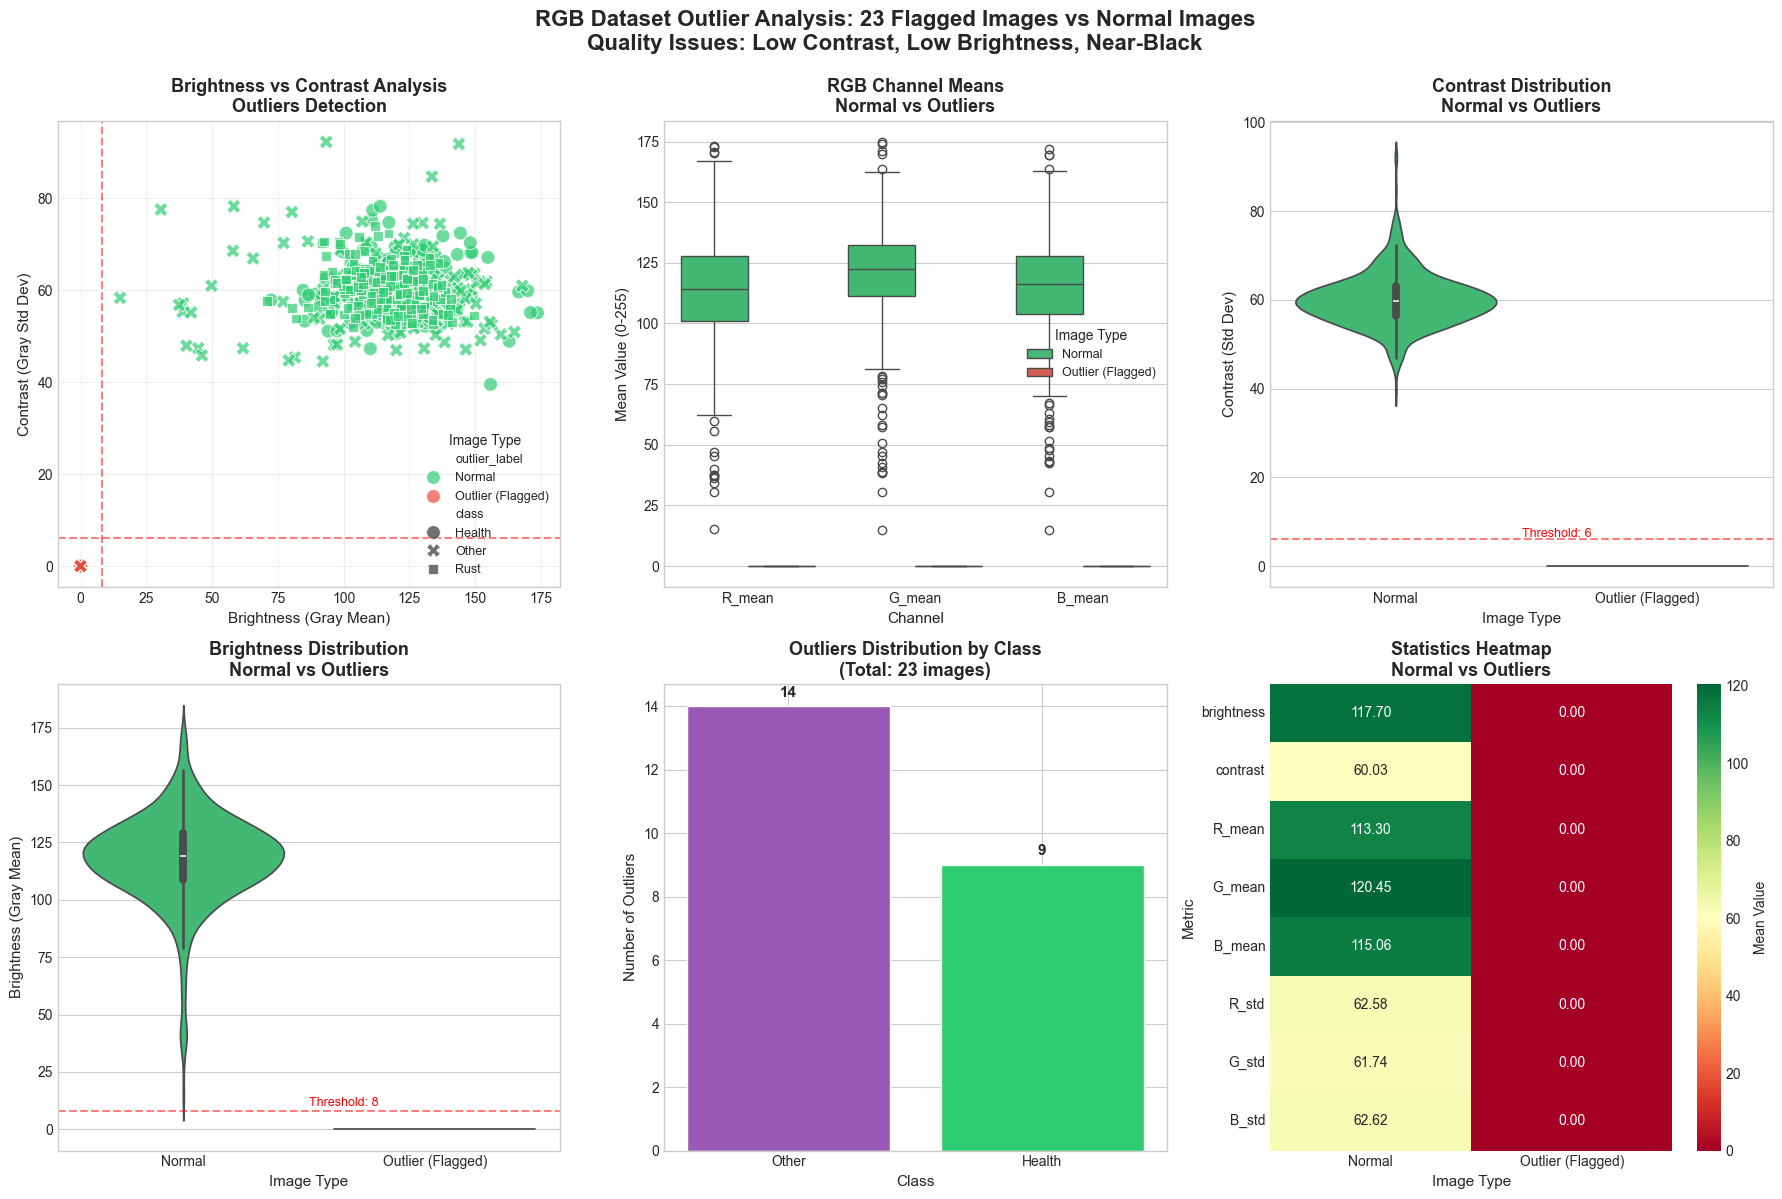

✅ Saved: rgb_outlier_analysis_comprehensive.png

📸 Generating outlier images visualization grid...


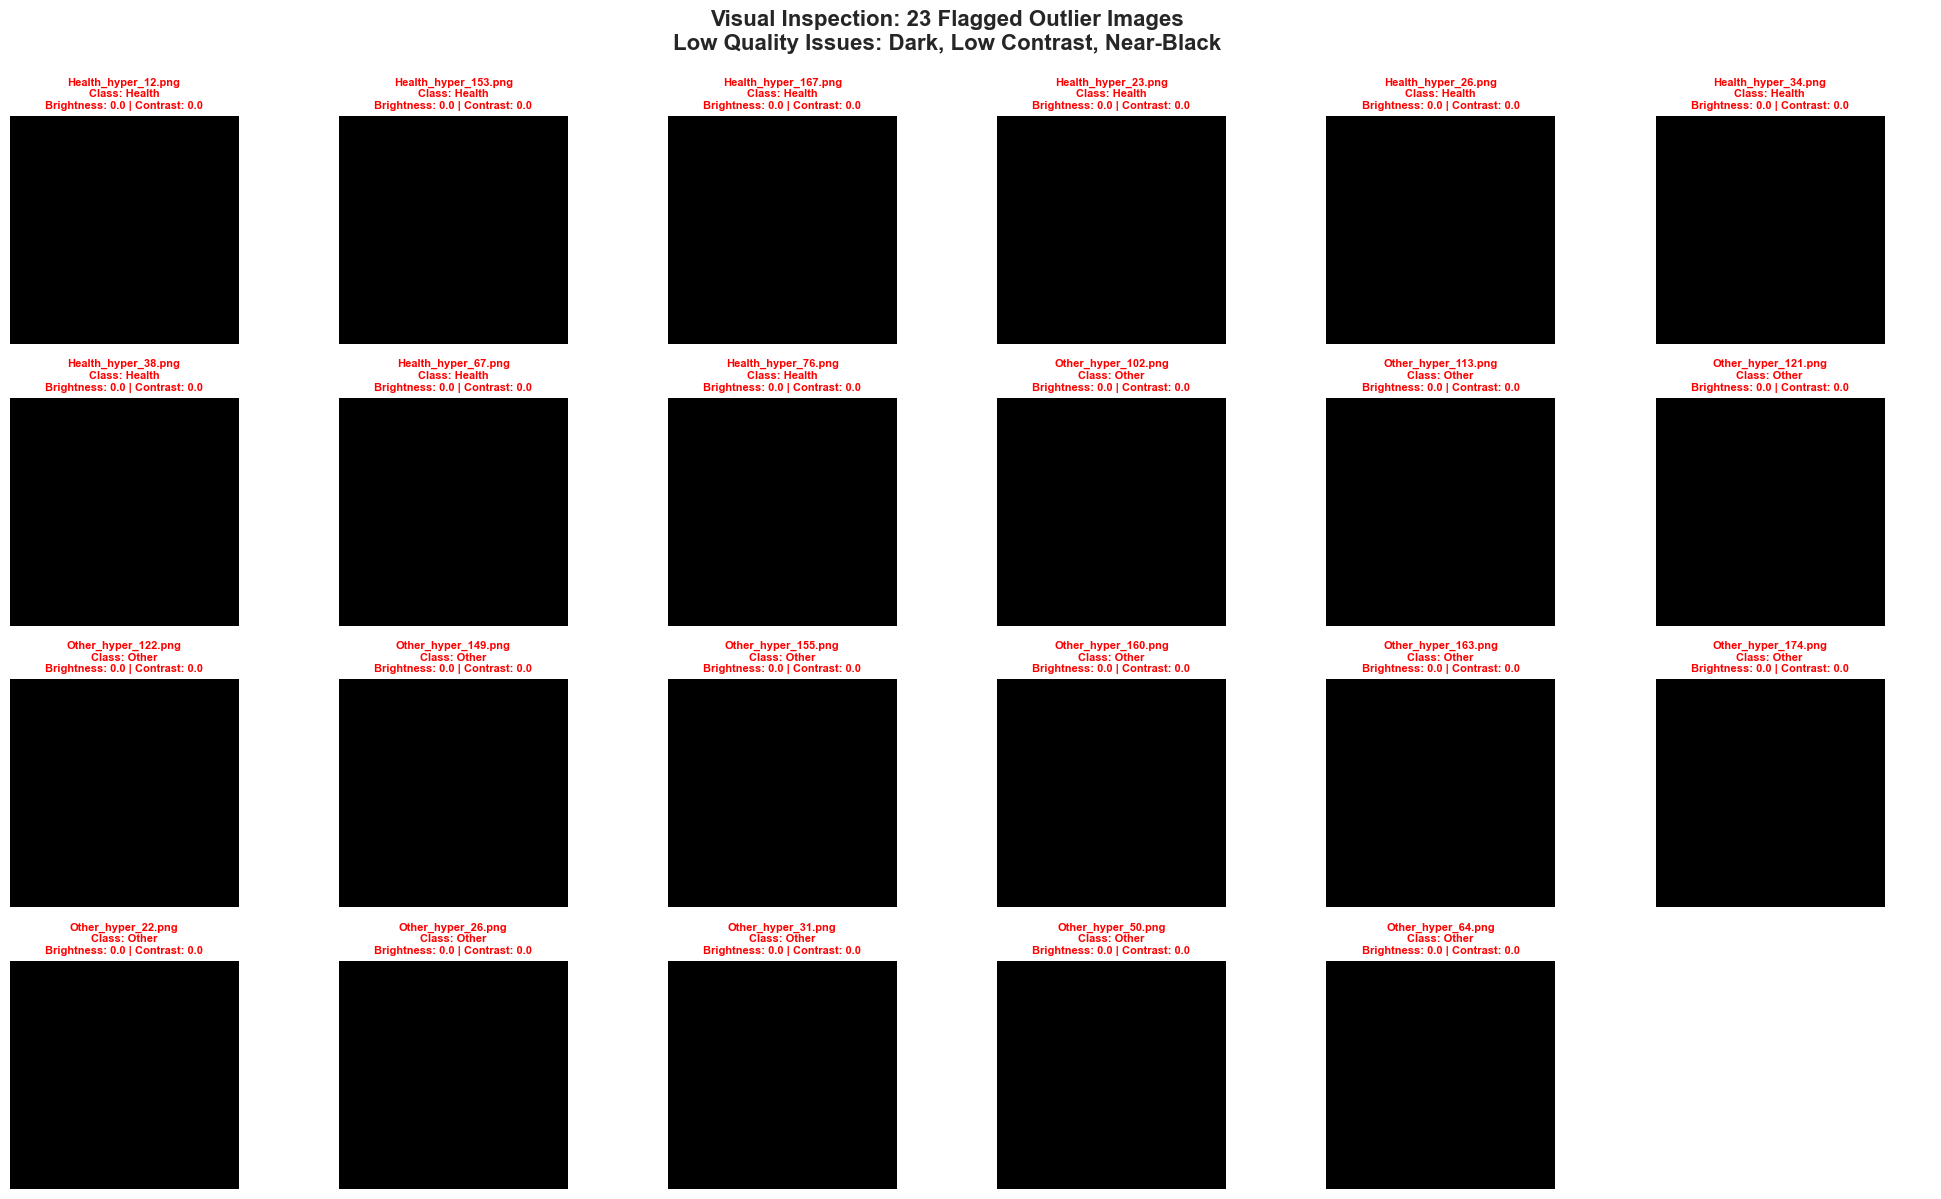

✅ Saved: rgb_outlier_images_grid.png

📋 DETAILED OUTLIER STATISTICS TABLE


,filename,class,brightness,contrast,R_mean,G_mean,B_mean,R_std,G_std,B_std
23,Health_hyper_12.png,Health,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
60,Health_hyper_153.png,Health,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75,Health_hyper_167.png,Health,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
116,Health_hyper_23.png,Health,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
119,Health_hyper_26.png,Health,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
128,Health_hyper_34.png,Health,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
132,Health_hyper_38.png,Health,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
164,Health_hyper_67.png,Health,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
174,Health_hyper_76.png,Health,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
204,Other_hyper_102.png,Other,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00



✅ OUTLIER ANALYSIS COMPLETE!

📁 Generated files:
   1. rgb_all_images_stats_with_outliers.csv
   2. rgb_outlier_analysis_comprehensive.png (6 analysis plots)
   3. rgb_outlier_images_grid.png (visual grid of 23 outliers)

🎯 Key Findings:
   - Total outliers: 23 / 600 images (3.8%)
   - Health outliers: 9 images
   - Other outliers:  14 images
   - Rust outliers:   0 images

   - Average brightness (Normal):  117.70
   - Average brightness (Outlier): 0.00
   - Average contrast (Normal):    60.03
   - Average contrast (Outlier):   0.00


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import glob

# ========= CONFIG =========
TRAIN_RGB_DIR = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB"
CLASSES = ["Health", "Other", "Rust"]

# ========= BLACKLIST (23 OUTLIER IMAGES) =========
BLACKLIST_FILES = {
    "Health_hyper_12.png",
    "Health_hyper_153.png",
    "Health_hyper_167.png",
    "Health_hyper_23.png",
    "Health_hyper_26.png",
    "Health_hyper_34.png",
    "Health_hyper_38.png",
    "Health_hyper_67.png",
    "Health_hyper_76.png",
    "Other_hyper_102.png",
    "Other_hyper_113.png",
    "Other_hyper_121.png",
    "Other_hyper_122.png",
    "Other_hyper_149.png",
    "Other_hyper_155.png",
    "Other_hyper_160.png",
    "Other_hyper_163.png",
    "Other_hyper_174.png",
    "Other_hyper_22.png",
    "Other_hyper_26.png",
    "Other_hyper_31.png",
    "Other_hyper_50.png",
    "Other_hyper_64.png",
}

# ========= STEP 1: COMPUTE STATISTICS FOR ALL IMAGES =========
print("🔬 Computing statistics for all images...")

def compute_image_stats(img_path):
    """Compute comprehensive stats for an image."""
    try:
        img = Image.open(img_path).convert("RGB")
        arr = np.array(img, dtype=np.float32)  # (H, W, 3)
        
        # Per-channel stats
        r, g, b = arr[:,:,0], arr[:,:,1], arr[:,:,2]
        
        # Grayscale for overall stats
        gray = 0.299*r + 0.587*g + 0.114*b
        
        return {
            'R_mean': r.mean(),
            'G_mean': g.mean(),
            'B_mean': b.mean(),
            'R_std': r.std(),
            'G_std': g.std(),
            'B_std': b.std(),
            'gray_mean': gray.mean(),
            'gray_std': gray.std(),
            'brightness': gray.mean(),  # Overall brightness
            'contrast': gray.std(),     # Overall contrast
            'R_min': r.min(),
            'R_max': r.max(),
            'G_min': g.min(),
            'G_max': g.max(),
            'B_min': b.min(),
            'B_max': b.max(),
        }
    except Exception as e:
        print(f"⚠️ Error reading {img_path}: {e}")
        return None

# Scan all images
files = sorted([f for f in os.listdir(TRAIN_RGB_DIR) if f.lower().endswith(".png")])

print(f"📊 Processing {len(files)} images...")

rows = []
for fname in files:
    fpath = os.path.join(TRAIN_RGB_DIR, fname)
    
    # Extract class label
    class_label = fname.split("_")[0]
    if class_label not in CLASSES:
        continue
    
    # Compute stats
    stats = compute_image_stats(fpath)
    if stats is None:
        continue
    
    # Mark as outlier or normal
    is_outlier = fname in BLACKLIST_FILES
    
    rows.append({
        'filename': fname,
        'class': class_label,
        'is_outlier': is_outlier,
        'outlier_label': 'Outlier (Flagged)' if is_outlier else 'Normal',
        **stats
    })

df_all = pd.DataFrame(rows)

print(f"✅ Processed {len(df_all)} images")
print(f"   - Normal images:  {len(df_all[~df_all['is_outlier']])} images")
print(f"   - Outlier images: {len(df_all[df_all['is_outlier']])} images")

# Save full statistics
df_all.to_csv("rgb_all_images_stats_with_outliers.csv", index=False, encoding='utf-8-sig')
print("\n💾 Saved: rgb_all_images_stats_with_outliers.csv")

# ========= STEP 2: STATISTICAL COMPARISON =========
print("\n" + "=" * 80)
print("📊 STATISTICAL COMPARISON: OUTLIERS vs NORMAL IMAGES")
print("=" * 80)

df_normal = df_all[~df_all['is_outlier']]
df_outliers = df_all[df_all['is_outlier']]

comparison_metrics = ['brightness', 'contrast', 'R_mean', 'G_mean', 'B_mean', 
                     'R_std', 'G_std', 'B_std']

print("\nMETRIC COMPARISON:")
print("-" * 80)
print(f"{'Metric':<15} {'Normal Mean':<15} {'Outlier Mean':<15} {'Difference':<15}")
print("-" * 80)

for metric in comparison_metrics:
    normal_mean = df_normal[metric].mean()
    outlier_mean = df_outliers[metric].mean()
    diff = outlier_mean - normal_mean
    
    print(f"{metric:<15} {normal_mean:>14.2f} {outlier_mean:>15.2f} {diff:>15.2f}")

# ========= STEP 3: VISUALIZATION - MULTIPLE PLOTS =========
print("\n📊 Generating comprehensive outlier analysis plots...")

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# ========= FIGURE 1: BRIGHTNESS vs CONTRAST SCATTER PLOT =========
fig = plt.figure(figsize=(18, 12))

# Plot 1: Brightness vs Contrast
ax1 = plt.subplot(2, 3, 1)
sns.scatterplot(
    data=df_all,
    x='brightness',
    y='contrast',
    hue='outlier_label',
    style='class',
    s=100,
    alpha=0.7,
    palette={'Normal': '#2ECC71', 'Outlier (Flagged)': '#E74C3C'},
    ax=ax1
)
ax1.set_title('Brightness vs Contrast Analysis\nOutliers Detection', 
             fontsize=13, fontweight='bold')
ax1.set_xlabel('Brightness (Gray Mean)', fontsize=11)
ax1.set_ylabel('Contrast (Gray Std Dev)', fontsize=11)
ax1.legend(title='Image Type', fontsize=9, title_fontsize=10)
ax1.grid(True, alpha=0.3)

# Add threshold lines
ax1.axhline(6, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Low Contrast Threshold')
ax1.axvline(8, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Low Brightness Threshold')

# Plot 2: RGB Mean Distribution (Boxplot)
ax2 = plt.subplot(2, 3, 2)
df_melted = df_all.melt(
    id_vars=['filename', 'outlier_label'],
    value_vars=['R_mean', 'G_mean', 'B_mean'],
    var_name='channel',
    value_name='mean_value'
)
sns.boxplot(
    data=df_melted,
    x='channel',
    y='mean_value',
    hue='outlier_label',
    ax=ax2,
    palette={'Normal': '#2ECC71', 'Outlier (Flagged)': '#E74C3C'}
)
ax2.set_title('RGB Channel Means\nNormal vs Outliers', fontsize=13, fontweight='bold')
ax2.set_xlabel('Channel', fontsize=11)
ax2.set_ylabel('Mean Value (0-255)', fontsize=11)
ax2.legend(title='Image Type', fontsize=9, title_fontsize=10)

# Plot 3: Contrast Distribution (Violin Plot)
ax3 = plt.subplot(2, 3, 3)
sns.violinplot(
    data=df_all,
    x='outlier_label',
    y='contrast',
    ax=ax3,
    palette={'Normal': '#2ECC71', 'Outlier (Flagged)': '#E74C3C'},
    inner='box'
)
ax3.set_title('Contrast Distribution\nNormal vs Outliers', fontsize=13, fontweight='bold')
ax3.set_xlabel('Image Type', fontsize=11)
ax3.set_ylabel('Contrast (Std Dev)', fontsize=11)
ax3.axhline(6, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
ax3.text(0.5, 6.5, 'Threshold: 6', fontsize=9, color='red')

# Plot 4: Brightness Distribution (Violin Plot)
ax4 = plt.subplot(2, 3, 4)
sns.violinplot(
    data=df_all,
    x='outlier_label',
    y='brightness',
    ax=ax4,
    palette={'Normal': '#2ECC71', 'Outlier (Flagged)': '#E74C3C'},
    inner='box'
)
ax4.set_title('Brightness Distribution\nNormal vs Outliers', fontsize=13, fontweight='bold')
ax4.set_xlabel('Image Type', fontsize=11)
ax4.set_ylabel('Brightness (Gray Mean)', fontsize=11)
ax4.axhline(8, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
ax4.text(0.5, 10, 'Threshold: 8', fontsize=9, color='red')

# Plot 5: Class Distribution of Outliers
ax5 = plt.subplot(2, 3, 5)
outlier_class_counts = df_outliers['class'].value_counts()
colors_class = {'Health': '#2ECC71', 'Other': '#9B59B6', 'Rust': '#E74C3C'}
bars = ax5.bar(outlier_class_counts.index, outlier_class_counts.values,
               color=[colors_class.get(c, '#999999') for c in outlier_class_counts.index])
ax5.set_title('Outliers Distribution by Class\n(Total: 23 images)', 
             fontsize=13, fontweight='bold')
ax5.set_xlabel('Class', fontsize=11)
ax5.set_ylabel('Number of Outliers', fontsize=11)

# Add value labels on bars
for i, (cls, count) in enumerate(outlier_class_counts.items()):
    ax5.text(i, count + 0.3, str(count), ha='center', fontweight='bold', fontsize=11)

# Plot 6: Heatmap of Mean Statistics
ax6 = plt.subplot(2, 3, 6)
stats_summary = df_all.groupby('outlier_label')[comparison_metrics].mean()
sns.heatmap(
    stats_summary.T,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    ax=ax6,
    cbar_kws={'label': 'Mean Value'}
)
ax6.set_title('Statistics Heatmap\nNormal vs Outliers', fontsize=13, fontweight='bold')
ax6.set_xlabel('Image Type', fontsize=11)
ax6.set_ylabel('Metric', fontsize=11)

plt.suptitle('RGB Dataset Outlier Analysis: 23 Flagged Images vs Normal Images\n'
             'Quality Issues: Low Contrast, Low Brightness, Near-Black',
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('rgb_outlier_analysis_comprehensive.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: rgb_outlier_analysis_comprehensive.png")

# ========= FIGURE 2: DETAILED OUTLIER IMAGES GRID =========
print("\n📸 Generating outlier images visualization grid...")

outlier_files = sorted(list(BLACKLIST_FILES))
n_outliers = len(outlier_files)
n_cols = 6
n_rows = (n_outliers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, fname in enumerate(outlier_files):
    ax = axes[idx]
    
    img_path = os.path.join(TRAIN_RGB_DIR, fname)
    
    try:
        img = Image.open(img_path).convert("RGB")
        arr = np.array(img)
        
        # Display image
        ax.imshow(arr)
        ax.axis('off')
        
        # Get stats for this image
        img_stats = df_all[df_all['filename'] == fname].iloc[0]
        
        # Add title with stats
        title_text = f"{fname}\n"
        title_text += f"Class: {img_stats['class']}\n"
        title_text += f"Brightness: {img_stats['brightness']:.1f} | Contrast: {img_stats['contrast']:.1f}"
        
        ax.set_title(title_text, fontsize=8, fontweight='bold', 
                    color='red', pad=5)
        
    except Exception as e:
        ax.text(0.5, 0.5, f"Error\n{fname}", ha='center', va='center', fontsize=8)
        ax.axis('off')

# Hide extra subplots
for idx in range(n_outliers, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Visual Inspection: 23 Flagged Outlier Images\n'
             'Low Quality Issues: Dark, Low Contrast, Near-Black',
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('rgb_outlier_images_grid.png', dpi=120, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: rgb_outlier_images_grid.png")

# ========= STEP 4: DETAILED STATISTICS TABLE =========
print("\n" + "=" * 80)
print("📋 DETAILED OUTLIER STATISTICS TABLE")
print("=" * 80)

df_outliers_sorted = df_outliers.sort_values(['class', 'brightness'])

# Style DataFrame
styled_outliers = (
    df_outliers_sorted[['filename', 'class', 'brightness', 'contrast', 
                        'R_mean', 'G_mean', 'B_mean', 'R_std', 'G_std', 'B_std']]
    .style
    .background_gradient(subset=['brightness', 'contrast'], cmap='RdYlGn')
    .format({
        'brightness': '{:.2f}',
        'contrast': '{:.2f}',
        'R_mean': '{:.2f}',
        'G_mean': '{:.2f}',
        'B_mean': '{:.2f}',
        'R_std': '{:.2f}',
        'G_std': '{:.2f}',
        'B_std': '{:.2f}'
    })
    .set_caption("23 Outlier Images - Detailed Statistics")
)

display(styled_outliers)

# ========= FINAL SUMMARY =========
print("\n" + "=" * 80)
print("✅ OUTLIER ANALYSIS COMPLETE!")
print("=" * 80)
print("\n📁 Generated files:")
print("   1. rgb_all_images_stats_with_outliers.csv")
print("   2. rgb_outlier_analysis_comprehensive.png (6 analysis plots)")
print("   3. rgb_outlier_images_grid.png (visual grid of 23 outliers)")
print("\n🎯 Key Findings:")
print(f"   - Total outliers: {len(df_outliers)} / {len(df_all)} images ({len(df_outliers)/len(df_all)*100:.1f}%)")
print(f"   - Health outliers: {len(df_outliers[df_outliers['class']=='Health'])} images")
print(f"   - Other outliers:  {len(df_outliers[df_outliers['class']=='Other'])} images")
print(f"   - Rust outliers:   {len(df_outliers[df_outliers['class']=='Rust'])} images")
print(f"\n   - Average brightness (Normal):  {df_normal['brightness'].mean():.2f}")
print(f"   - Average brightness (Outlier): {df_outliers['brightness'].mean():.2f}")
print(f"   - Average contrast (Normal):    {df_normal['contrast'].mean():.2f}")
print(f"   - Average contrast (Outlier):   {df_outliers['contrast'].mean():.2f}")
print("=" * 80)

# check ảnh đen/ ít giá trị

dtype: uint8 shape: (64, 64, 3) min/max: 0 0


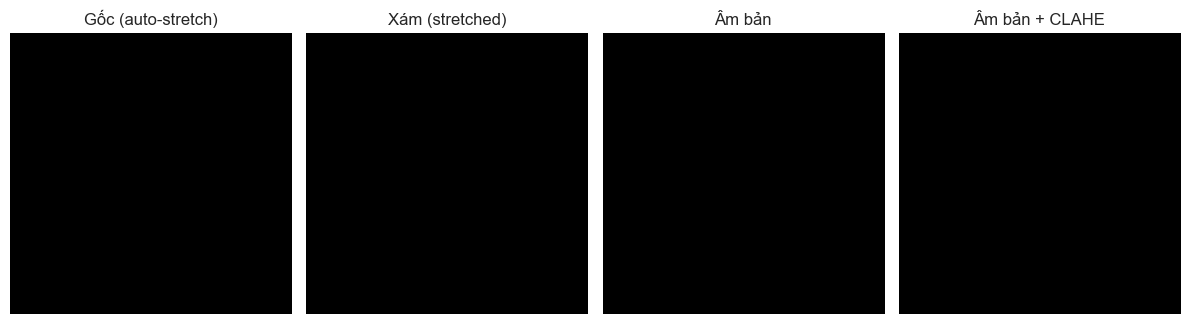

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

path = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Health_hyper_12.png "

# 1) Đọc đúng kiểu (giữ nguyên bit-depth)
img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
if img is None:
    raise FileNotFoundError(f"Không đọc được ảnh: {path}")

print("dtype:", img.dtype, "shape:", img.shape, "min/max:", img.min(), img.max())

def stretch_to_u8(x, p1=1, p99=99):
    """Auto contrast stretch về uint8 0..255 (bền hơn min-max vì tránh outlier)."""
    x = x.astype(np.float32)
    lo = np.percentile(x, p1)
    hi = np.percentile(x, p99)
    if hi <= lo + 1e-6:
        return np.zeros_like(x, dtype=np.uint8)
    y = (x - lo) / (hi - lo)
    y = np.clip(y, 0, 1)
    return (y * 255).astype(np.uint8)

# 2) Chuẩn hoá để HIỂN THỊ
if img.ndim == 3:
    # nếu có alpha thì bỏ
    if img.shape[2] == 4:
        img = img[:, :, :3]

    # OpenCV là BGR -> stretch từng kênh -> đổi sang RGB để plt
    bgr_u8 = np.dstack([stretch_to_u8(img[..., c]) for c in range(3)])
    rgb = cv2.cvtColor(bgr_u8, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(bgr_u8, cv2.COLOR_BGR2GRAY)
else:
    rgb = None
    gray = stretch_to_u8(img)

# 3) Âm bản + CLAHE (trên ảnh đã được stretch)
neg = 255 - gray
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
neg_clahe = clahe.apply(neg)

# 4) Vẽ
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
if rgb is not None:
    plt.imshow(rgb)
    plt.title("Gốc (auto-stretch)")
else:
    plt.imshow(gray, cmap="gray")
    plt.title("Gốc xám (auto-stretch)")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(gray, cmap="gray")
plt.title("Xám (stretched)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(neg, cmap="gray")
plt.title("Âm bản")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(neg_clahe, cmap="gray")
plt.title("Âm bản + CLAHE")
plt.axis("off")

plt.tight_layout()
plt.show()


In [12]:
import cv2, numpy as np

p = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Health_hyper_23.png"
img = cv2.imread(p, cv2.IMREAD_UNCHANGED)

print("shape:", img.shape, "dtype:", img.dtype)
print("overall min/max:", img.min(), img.max())

if img.ndim == 3 and img.shape[2] == 4:
    b,g,r,a = cv2.split(img)
    print("B min/max:", b.min(), b.max())
    print("G min/max:", g.min(), g.max())
    print("R min/max:", r.min(), r.max())
    print("A min/max:", a.min(), a.max())


shape: (64, 64, 3) dtype: uint8
overall min/max: 0 0


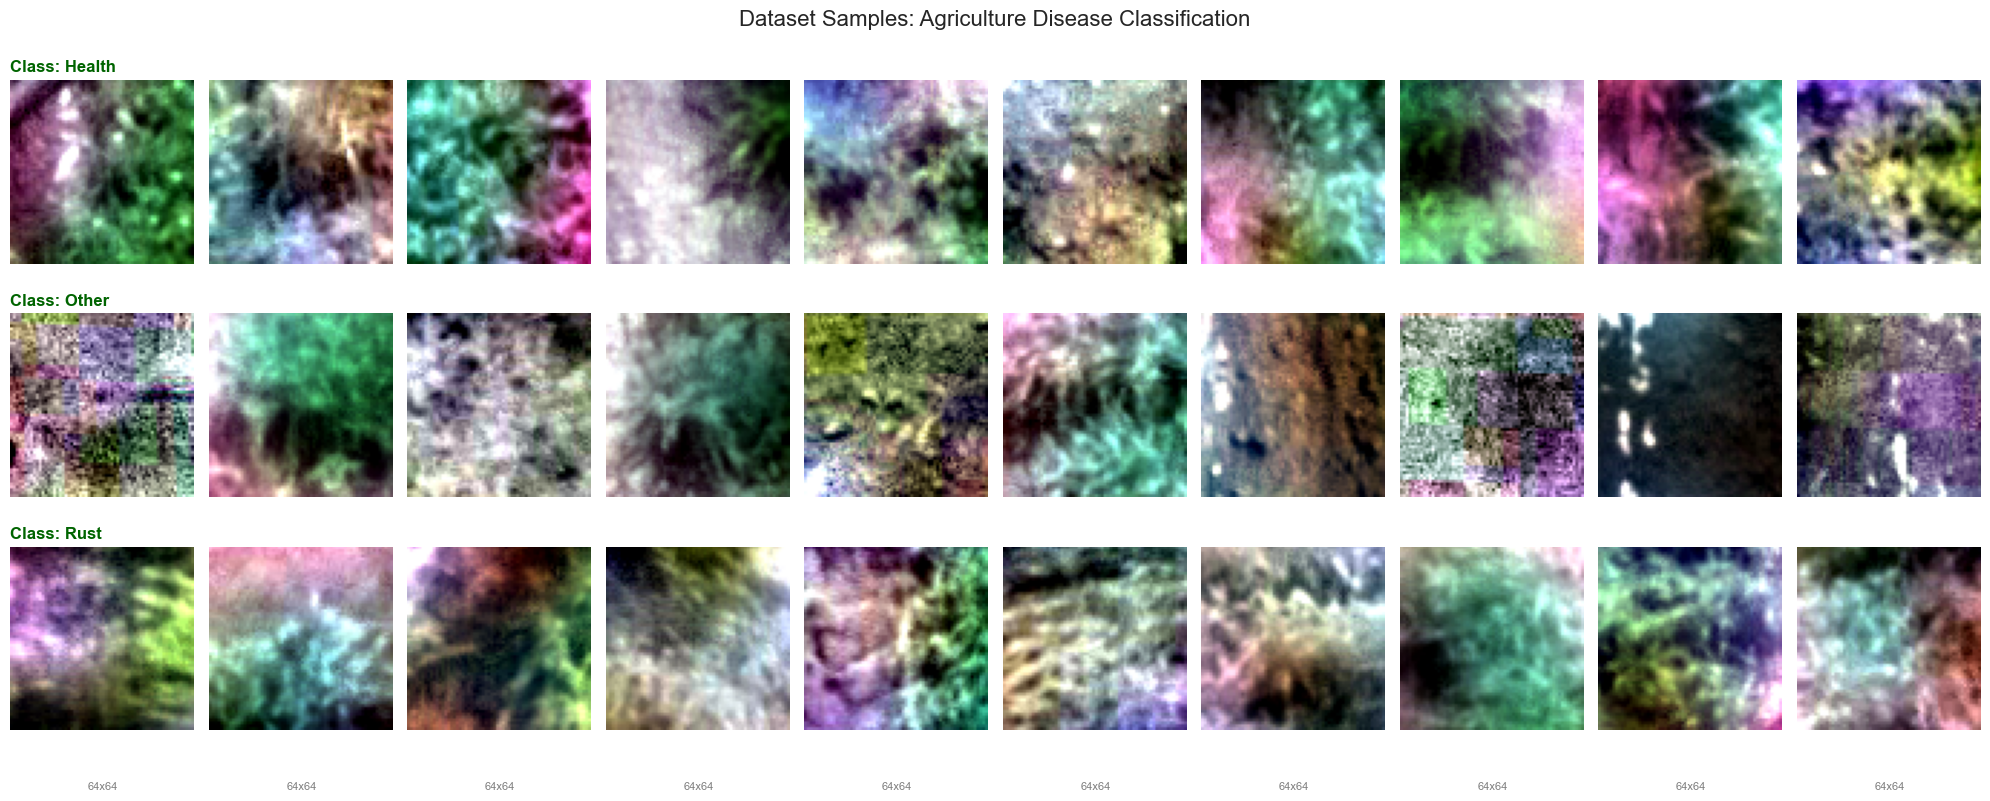

In [13]:
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Cấu hình đường dẫn và thông số
DATA_DIR = Path(r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB")
CLASSES = ["Health", "Other", "Rust"]
N_PER_CLASS = 10
SEED = 12

def visualize_dataset_grid(data_dir, classes, n_per_row=10, seed=42):
    random.seed(seed)
    
    # 1. Thu thập dữ liệu thông minh hơn với Pathlib
    all_files = []
    for ext in ("*.png", "*.jpg", "*.jpeg"):
        all_files.extend(list(data_dir.glob(ext)))
    
    # 2. Phân loại ảnh theo nhãn
    data_map = {cls: [] for cls in classes}
    for p in all_files:
        label = p.name.split("_")[0]
        if label in data_map:
            data_map[label].append(p)
            
    # 3. Setup Figure
    n_rows = len(classes)
    fig, axes = plt.subplots(n_rows, n_per_row, figsize=(2 * n_per_row, 2.5 * n_rows))
    fig.suptitle("Dataset Samples: Agriculture Disease Classification", fontsize=16, y=1.02)

    for i, cls in enumerate(classes):
        paths = data_map[cls]
        
        # Chọn mẫu ngẫu nhiên (nếu không đủ thì lấy hết)
        n_samples = min(len(paths), n_per_row)
        selected_paths = random.sample(paths, n_samples) if paths else []
        
        for j in range(n_per_row):
            ax = axes[i, j] if n_rows > 1 else axes[j]
            ax.axis("off")
            
            if j < len(selected_paths):
                img_path = str(selected_paths[j])
                # Đọc ảnh và chuyển hệ màu
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    h, w, _ = img.shape
                    ax.imshow(img)
                    
                    # Thêm thông số kích thước nhỏ ở dưới mỗi ảnh để dễ soi lỗi size
                    ax.text(w//2, h+20, f"{w}x{h}", fontsize=8, ha='center', color='gray')
                else:
                    ax.text(0.5, 0.5, "Error", ha='center')
            
            # Đặt tên lớp ở cột đầu tiên
            if j == 0:
                ax.set_title(f"Class: {cls}", loc='left', fontsize=12, fontweight='bold', color='darkgreen')

    plt.tight_layout()
    plt.show()

# Thực thi
visualize_dataset_grid(DATA_DIR, CLASSES, n_per_row=N_PER_CLASS, seed=SEED)

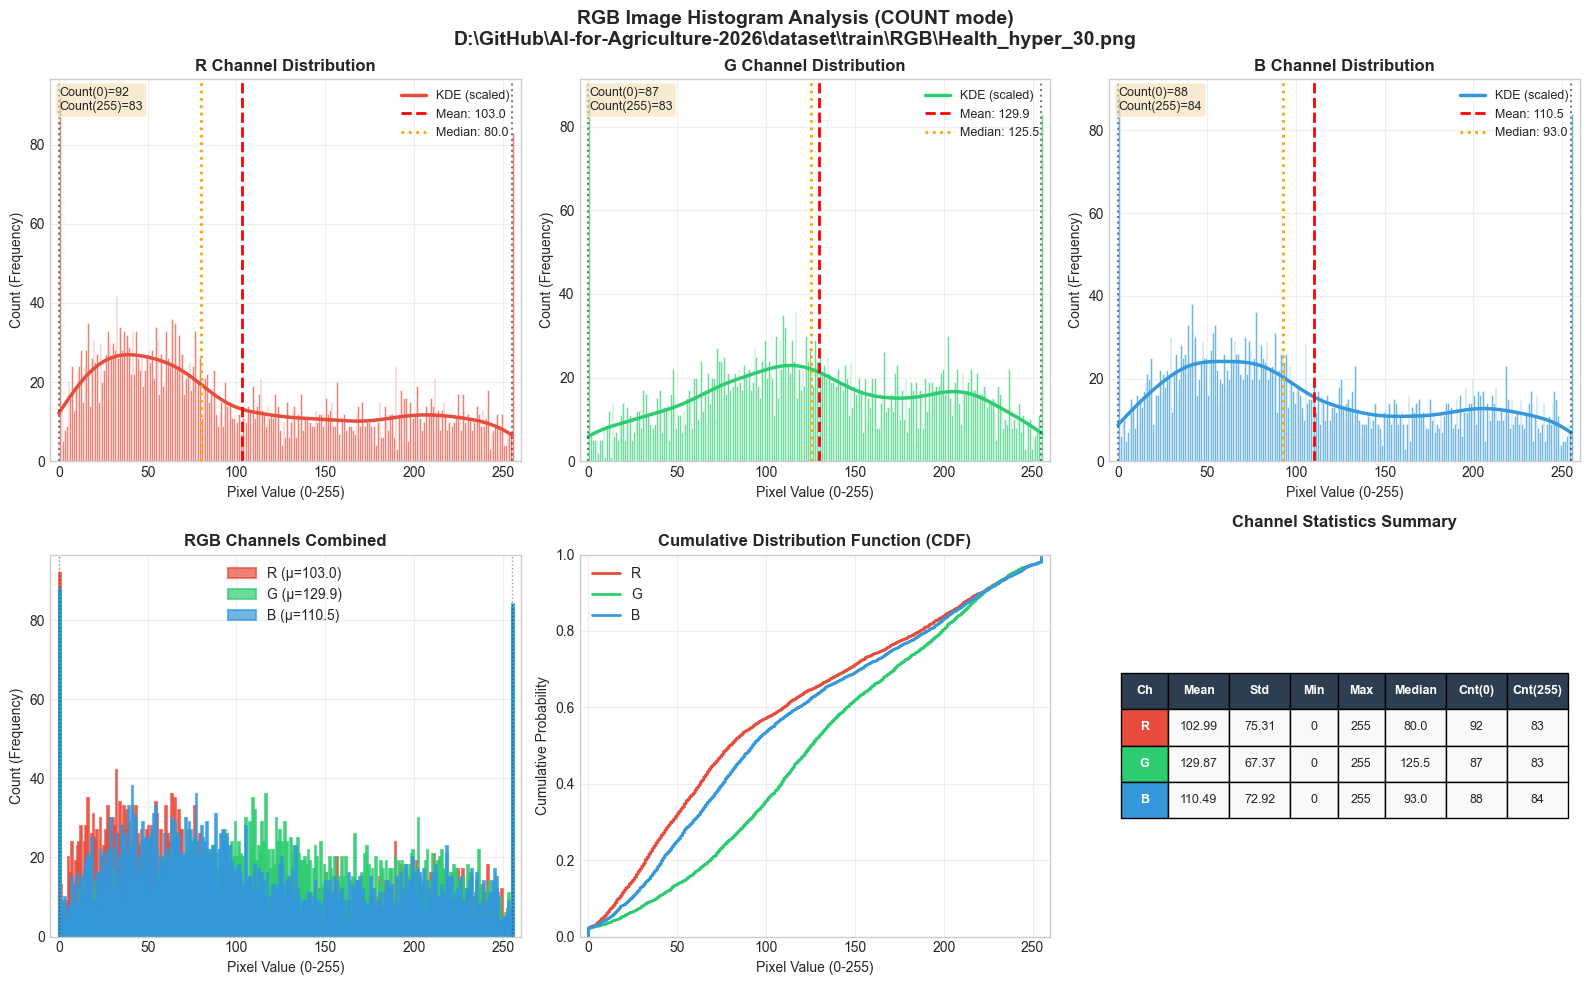

CHANNEL STATISTICS SUMMARY

R Channel:
  Mean:      102.99
  Std:       75.31
  Min:       0
  Max:       255
  Median:    80.0
  Range:     255
  Count(0):  92 pixels (0.75%)
  Count(255):83 pixels (0.68%)

G Channel:
  Mean:      129.87
  Std:       67.37
  Min:       0
  Max:       255
  Median:    125.5
  Range:     255
  Count(0):  87 pixels (0.71%)
  Count(255):83 pixels (0.68%)

B Channel:
  Mean:      110.49
  Std:       72.92
  Min:       0
  Max:       255
  Median:    93.0
  Range:     255
  Count(0):  88 pixels (0.72%)
  Count(255):84 pixels (0.68%)

IMAGE INFORMATION
Shape: (64, 64, 3) (Height x Width x Channels)
Total Pixels: 4,096
Data Type: uint8
Memory Size: 12.00 KB

💾 Figure saved: rgb_histogram_analysis_count.png


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

img_path = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB\Health_hyper_30.png"

# Load image
img = Image.open(img_path).convert("RGB")
arr = np.array(img)  # (H,W,3), uint8 0..255

# Tính thống kê cho mỗi kênh
stats = {}
for i, ch in enumerate(['R', 'G', 'B']):
    channel_data = arr[:,:,i].ravel()
    stats[ch] = {
        'mean': np.mean(channel_data),
        'std': np.std(channel_data),
        'min': np.min(channel_data),
        'max': np.max(channel_data),
        'median': np.median(channel_data),
        'count_0': int((channel_data == 0).sum()),
        'count_255': int((channel_data == 255).sum())
    }

# Visualization với style chuyên nghiệp
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 10))

colors = {'R': '#E74C3C', 'G': '#2ECC71', 'B': '#3498DB'}

# QUAN TRỌNG: bins phải cover đúng range 0-256 để bin chứa giá trị 0 và 255
bins = np.arange(257)  # 0, 1, 2, ..., 256 => tạo 256 bins

# Histogram riêng cho từng kênh
for i, ch in enumerate(['R', 'G', 'B']):
    ax = plt.subplot(2, 3, i+1)
    channel_data = arr[:,:,i].ravel()
    
    # Histogram với COUNT (không phải density)
    n, bin_edges, patches = ax.hist(channel_data, bins=bins, range=(0, 256),
                                     color=colors[ch], alpha=0.7, 
                                     edgecolor='white', linewidth=0.5)
    
    # Thêm KDE line (scale lên để khớp với count)
    from scipy import stats as sp_stats
    kde = sp_stats.gaussian_kde(channel_data)
    x_range = np.linspace(0, 255, 300)
    kde_values = kde(x_range)
    # Scale KDE để fit với histogram count
    kde_scaled = kde_values * len(channel_data) * (bin_edges[1] - bin_edges[0])
    ax.plot(x_range, kde_scaled, color=colors[ch], linewidth=2.5, label='KDE (scaled)')
    
    # Thêm mean/median lines
    ax.axvline(stats[ch]['mean'], color='red', linestyle='--', linewidth=2, 
               label=f"Mean: {stats[ch]['mean']:.1f}")
    ax.axvline(stats[ch]['median'], color='orange', linestyle=':', linewidth=2,
               label=f"Median: {stats[ch]['median']:.1f}")
    
    # Highlight vị trí 0 và 255
    if stats[ch]['count_0'] > 0:
        ax.axvline(0, color='black', linestyle=':', linewidth=1.5, alpha=0.5)
    if stats[ch]['count_255'] > 0:
        ax.axvline(255, color='black', linestyle=':', linewidth=1.5, alpha=0.5)
    
    ax.set_title(f'{ch} Channel Distribution', fontweight='bold', fontsize=12)
    ax.set_xlabel('Pixel Value (0-255)')
    ax.set_ylabel('Count (Frequency)')  # ĐÃ ĐỔI: COUNT thay vì Density
    ax.set_xlim(-5, 260)  # Mở rộng một chút để thấy rõ 0 và 255
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Text box với count_0 và count_255
    info_text = f"Count(0)={stats[ch]['count_0']}\nCount(255)={stats[ch]['count_255']}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))

# Combined histogram - ĐÂY LÀ PHẦN QUAN TRỌNG
ax4 = plt.subplot(2, 3, 4)
for i, ch in enumerate(['R', 'G', 'B']):
    channel_data = arr[:,:,i].ravel()
    # Dùng histtype='step' để overlay rõ ràng hơn
    ax4.hist(channel_data, bins=bins, range=(0, 256), 
             alpha=0.7, color=colors[ch],
             label=f'{ch} (μ={stats[ch]["mean"]:.1f})', 
             edgecolor=colors[ch], linewidth=1.5, histtype='bar')

ax4.set_title('RGB Channels Combined', fontweight='bold', fontsize=12)
ax4.set_xlabel('Pixel Value (0-255)')
ax4.set_ylabel('Count (Frequency)')  # COUNT
ax4.set_xlim(-5, 260)  # Để thấy rõ vùng 0 và 255
ax4.legend()
ax4.grid(True, alpha=0.3)

# Thêm vertical lines tại 0 và 255
ax4.axvline(0, color='black', linestyle=':', linewidth=1, alpha=0.4, label='Value 0')
ax4.axvline(255, color='black', linestyle=':', linewidth=1, alpha=0.4, label='Value 255')

# Cumulative Distribution Function
ax5 = plt.subplot(2, 3, 5)
for i, ch in enumerate(['R', 'G', 'B']):
    channel_data = arr[:,:,i].ravel()
    sorted_data = np.sort(channel_data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax5.plot(sorted_data, cdf, color=colors[ch], linewidth=2, label=ch)

ax5.set_title('Cumulative Distribution Function (CDF)', fontweight='bold', fontsize=12)
ax5.set_xlabel('Pixel Value (0-255)')
ax5.set_ylabel('Cumulative Probability')
ax5.set_xlim(-5, 260)
ax5.set_ylim(0, 1)
ax5.legend()
ax5.grid(True, alpha=0.3)

# Statistics Table - THÊM CỘT COUNT_0 VÀ COUNT_255
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

table_data = []
for ch in ['R', 'G', 'B']:
    table_data.append([
        ch,
        f"{stats[ch]['mean']:.2f}",
        f"{stats[ch]['std']:.2f}",
        f"{stats[ch]['min']}",
        f"{stats[ch]['max']}",
        f"{stats[ch]['median']:.1f}",
        f"{stats[ch]['count_0']}",
        f"{stats[ch]['count_255']}"
    ])

table = ax6.table(
    cellText=table_data,
    colLabels=['Ch', 'Mean', 'Std', 'Min', 'Max', 'Median', 'Cnt(0)', 'Cnt(255)'],
    cellLoc='center',
    loc='center',
    colWidths=[0.10, 0.13, 0.13, 0.10, 0.10, 0.13, 0.13, 0.13]
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Color code rows
for i, ch in enumerate(['R', 'G', 'B']):
    for j in range(8):
        cell = table[(i+1, j)]
        if j == 0:
            cell.set_facecolor(colors[ch])
            cell.set_text_props(color='white', weight='bold')
        else:
            cell.set_facecolor('#f8f9fa')

# Header styling
for j in range(8):
    table[(0, j)].set_facecolor('#2c3e50')
    table[(0, j)].set_text_props(color='white', weight='bold')

ax6.set_title('Channel Statistics Summary', fontweight='bold', fontsize=12, pad=20)

plt.suptitle(f'RGB Image Histogram Analysis (COUNT mode)\n{img_path.split("/")[-1]}', 
             fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('rgb_histogram_analysis_count.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Print statistics
print("=" * 70)
print("CHANNEL STATISTICS SUMMARY")
print("=" * 70)
for ch in ['R', 'G', 'B']:
    print(f"\n{ch} Channel:")
    print(f"  Mean:      {stats[ch]['mean']:.2f}")
    print(f"  Std:       {stats[ch]['std']:.2f}")
    print(f"  Min:       {stats[ch]['min']}")
    print(f"  Max:       {stats[ch]['max']}")
    print(f"  Median:    {stats[ch]['median']:.1f}")
    print(f"  Range:     {stats[ch]['max'] - stats[ch]['min']}")
    print(f"  Count(0):  {stats[ch]['count_0']:,} pixels ({stats[ch]['count_0']/arr.size*100:.2f}%)")
    print(f"  Count(255):{stats[ch]['count_255']:,} pixels ({stats[ch]['count_255']/arr.size*100:.2f}%)")

print("\n" + "=" * 70)
print("IMAGE INFORMATION")
print("=" * 70)
print(f"Shape: {arr.shape} (Height x Width x Channels)")
print(f"Total Pixels: {arr.shape[0] * arr.shape[1]:,}")
print(f"Data Type: {arr.dtype}")
print(f"Memory Size: {arr.nbytes / 1024:.2f} KB")
print("\n💾 Figure saved: rgb_histogram_analysis_count.png")

🔍 Scanning images...
🚫 Filtered out 23 flagged images
📊 Total valid images: 577 (excluded 23 flagged)
   - Health: 191 images
   - Other: 186 images
   - Rust: 200 images

📌 Picked 10 images per class (SEED=42):
   - Health: 10 images
   - Other: 10 images
   - Rust: 10 images

🔬 Collecting pixels (≈20,000 per image with stratified sampling)...
   ✓ Health: 40,960 pixels collected
   ✓ Other: 40,960 pixels collected
   ✓ Rust: 40,960 pixels collected

📋 Generating statistics table...


,class,channel,mean,std,min,max,median,p1,p99,count_eq_0,count_eq_255,n_pixels_used
0,Health,R,111.30,66.51,0,255,105.00,0.00,255.00,892,829,"40,960"
1,Health,G,120.62,64.24,0,255,120.00,0.00,255.00,882,829,"40,960"
2,Health,B,116.53,66.24,0,255,113.00,0.00,255.00,907,828,"40,960"
3,Other,R,116.19,69.08,0,255,116.00,0.00,255.00,920,824,"40,960"
4,Other,G,116.50,66.38,0,255,118.00,0.00,255.00,897,826,"40,960"
5,Other,B,110.39,65.26,0,255,108.00,0.00,255.00,920,827,"40,960"
6,Rust,R,107.00,61.97,0,255,101.00,0.00,255.00,889,834,"40,960"
7,Rust,G,121.28,62.01,0,255,122.00,0.00,255.00,903,825,"40,960"
8,Rust,B,116.46,63.04,0,255,115.00,0.00,255.00,868,832,"40,960"



✅ Saved stats table: rgb_stats_10_per_class_filtered.csv

📊 Generating histograms...


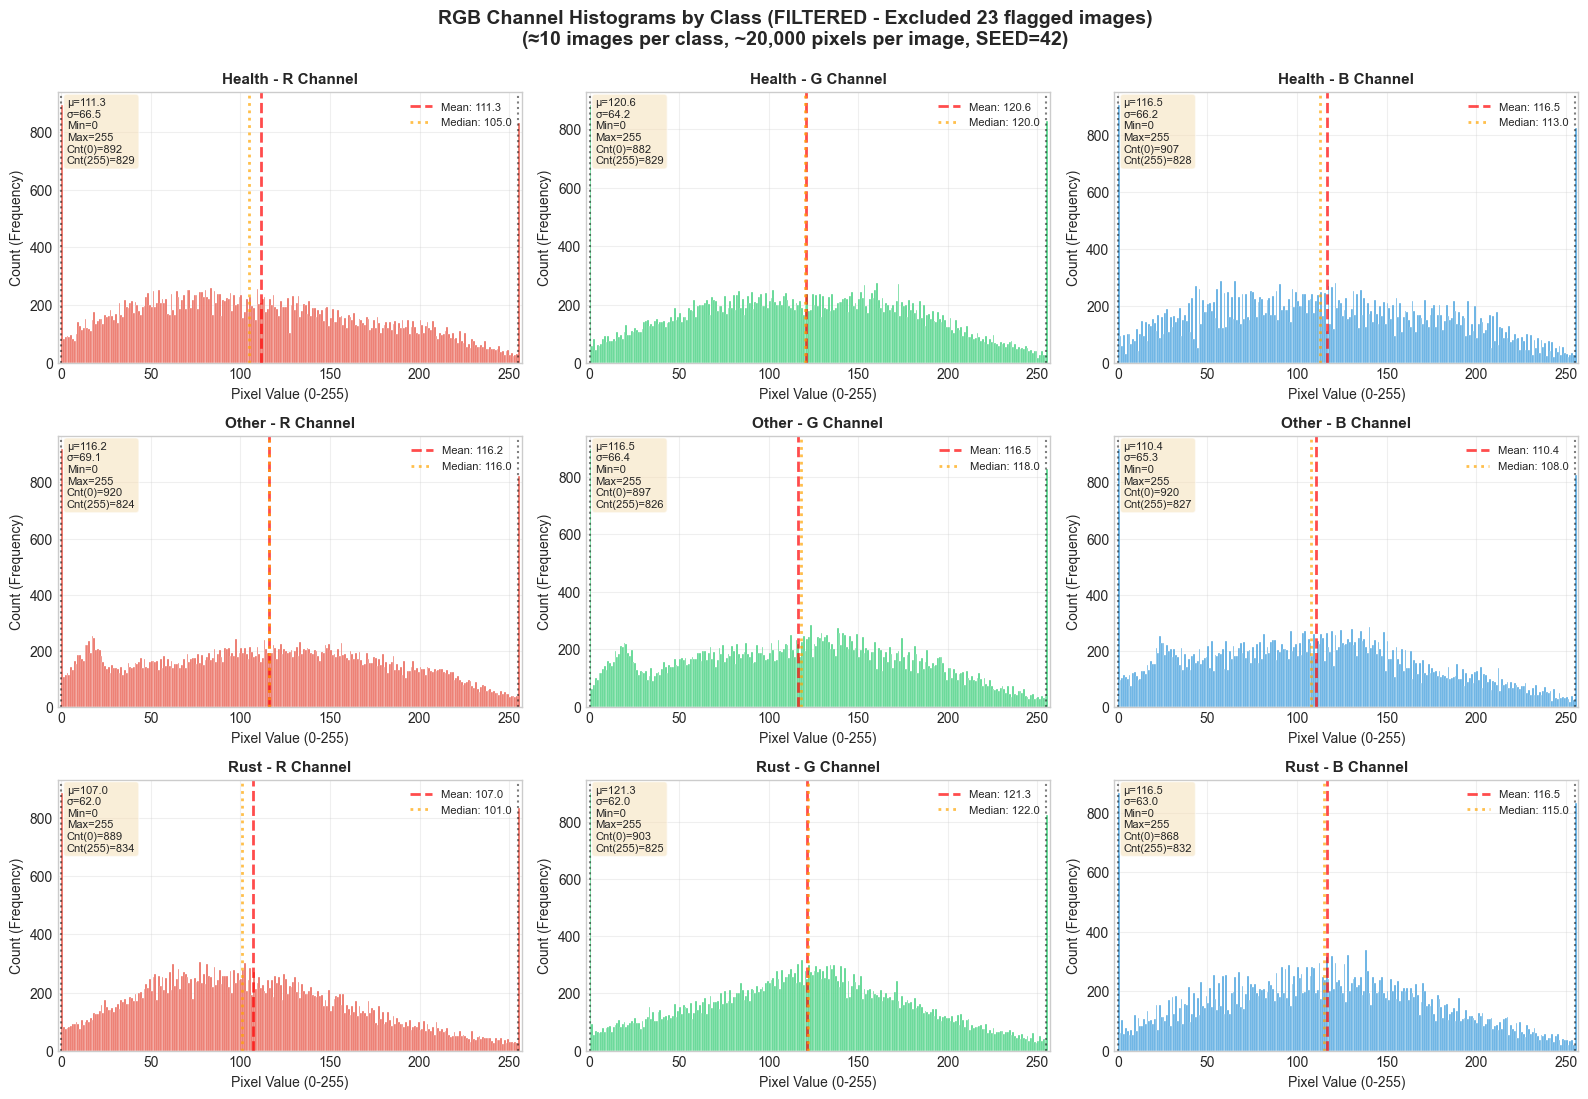

✅ Saved: rgb_hist_per_class_filtered.png


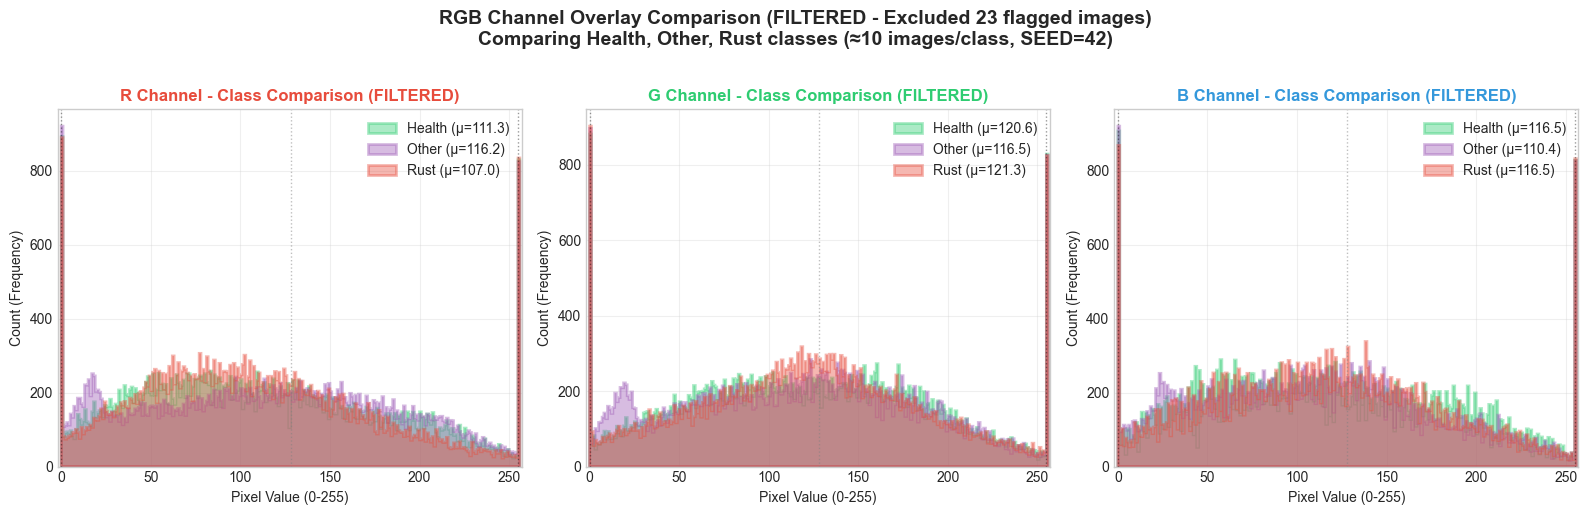

✅ Saved: rgb_hist_overlay_by_channel_filtered.png

📊 DETAILED STATISTICS SUMMARY (FILTERED)

🏷️  HEALTH CLASS:
--------------------------------------------------------------------------------

  R Channel:
    Mean:               111.30
    Std Dev:             66.51
    Median:             105.00
    Min/Max:             0 / 255
    P1/P99:               0.00 /  255.00
    Count == 0:            892 (2.18%)
    Count == 255:          829 (2.02%)
    Total pixels:       40,960

  G Channel:
    Mean:               120.62
    Std Dev:             64.24
    Median:             120.00
    Min/Max:             0 / 255
    P1/P99:               0.00 /  255.00
    Count == 0:            882 (2.15%)
    Count == 255:          829 (2.02%)
    Total pixels:       40,960

  B Channel:
    Mean:               116.53
    Std Dev:             66.24
    Median:             113.00
    Min/Max:             0 / 255
    P1/P99:               0.00 /  255.00
    Count == 0:            907 (2.21%)
    Coun

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# ========= CONFIG =========
TRAIN_RGB_DIR = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB"
CLASSES = ["Health", "Other", "Rust"]
N_PER_CLASS = 10
SEED = 42  # ⬅️ Thống nhất SEED

# Lấy bao nhiêu pixel mỗi ảnh để vẽ hist nhẹ hơn
PIX_PER_IMAGE = 20000

# ========= BLACKLIST - Danh sách ảnh bị loại =========
BLACKLIST_FILES = {
    "Health_hyper_12.png",
    "Health_hyper_153.png",
    "Health_hyper_167.png",
    "Health_hyper_23.png",
    "Health_hyper_26.png",
    "Health_hyper_34.png",
    "Health_hyper_38.png",
    "Health_hyper_67.png",
    "Health_hyper_76.png",
    "Other_hyper_102.png",
    "Other_hyper_113.png",
    "Other_hyper_121.png",
    "Other_hyper_122.png",
    "Other_hyper_149.png",
    "Other_hyper_155.png",
    "Other_hyper_160.png",
    "Other_hyper_163.png",
    "Other_hyper_174.png",
    "Other_hyper_22.png",
    "Other_hyper_26.png",
	 "Other_hyper_31.png",
	 "Other_hyper_50.png",
	 "Other_hyper_64.png",

}

# ========= HELPERS =========
def label_from_filename(fname: str) -> str:
    """Extract class label from filename."""
    for c in CLASSES:
        if fname.startswith(c):
            return c
    return "Unknown"

def load_rgb(path):
    """Load RGB image and convert to numpy array."""
    img = Image.open(path).convert("RGB")
    arr = np.array(img)  # uint8 (H,W,3) 0..255
    return arr

def sample_pixels_stratified(arr, rng, n=PIX_PER_IMAGE):
    """
    Sample pixels with stratified sampling to ensure rare values (0, 255) are included.
    """
    flat = arr.reshape(-1, 3)
    total_pixels = flat.shape[0]
    
    # Nếu ảnh nhỏ hơn n, lấy hết
    if total_pixels <= n:
        return flat
    
    # Tìm các pixel đặc biệt (0 hoặc 255 ở bất kỳ kênh nào)
    special_mask = ((flat == 0) | (flat == 255)).any(axis=1)
    special_idx = np.where(special_mask)[0]
    normal_idx = np.where(~special_mask)[0]
    
    # Ưu tiên lấy pixel đặc biệt (tối đa 25%)
    n_special = min(len(special_idx), n // 4)
    n_normal = n - n_special
    
    sampled = []
    if n_special > 0 and len(special_idx) > 0:
        sampled_special = rng.choice(special_idx, size=n_special, replace=False)
        sampled.append(flat[sampled_special])
    
    if n_normal > 0 and len(normal_idx) >= n_normal:
        sampled_normal = rng.choice(normal_idx, size=n_normal, replace=False)
        sampled.append(flat[sampled_normal])
    elif len(normal_idx) > 0:
        sampled.append(flat[normal_idx])
    
    if len(sampled) == 0:
        # Fallback: random sampling
        idx = rng.choice(total_pixels, size=min(n, total_pixels), replace=False)
        return flat[idx]
    
    return np.concatenate(sampled, axis=0)

def compute_stats_from_pixels(px_uint8):
    """Compute comprehensive statistics for each RGB channel."""
    out = {}
    for i, ch in enumerate(["R", "G", "B"]):
        v = px_uint8[:, i].astype(np.float32)
        out[ch] = {
            "mean": float(v.mean()),
            "std": float(v.std()),
            "min": int(v.min()),
            "max": int(v.max()),
            "median": float(np.median(v)),
            "p1": float(np.percentile(v, 1)),
            "p99": float(np.percentile(v, 99)),
            "count_eq_0": int((v == 0).sum()),
            "count_eq_255": int((v == 255).sum()),
            "n_pixels_used": int(v.shape[0]),
        }
    return out

# ========= 1) PICK IMAGES PER CLASS (FILTER BLACKLIST) =========
print("🔍 Scanning images...")
files = sorted([f for f in os.listdir(TRAIN_RGB_DIR) if f.lower().endswith(".png")])

# ⬅️ LỌC BỎ BLACKLIST
files_clean = [f for f in files if f not in BLACKLIST_FILES]
print(f"🚫 Filtered out {len(files) - len(files_clean)} flagged images")

by_class = {c: [] for c in CLASSES}

for f in files_clean:
    lab = label_from_filename(f)
    if lab in by_class:
        by_class[lab].append(f)

print(f"📊 Total valid images: {len(files_clean)} (excluded {len(BLACKLIST_FILES)} flagged)")
for c in CLASSES:
    print(f"   - {c}: {len(by_class[c])} images")

# Random sampling
rng = np.random.default_rng(SEED)
picked = {}
for c in CLASSES:
    cand = by_class[c]
    if len(cand) == 0:
        picked[c] = []
        continue
    if len(cand) <= N_PER_CLASS:
        picked[c] = cand
    else:
        picked[c] = list(rng.choice(cand, size=N_PER_CLASS, replace=False))

print(f"\n📌 Picked {N_PER_CLASS} images per class (SEED={SEED}):")
for c in CLASSES:
    print(f"   - {c}: {len(picked[c])} images")

# ========= 2) COLLECT PIXELS + COMPUTE STATS =========
print(f"\n🔬 Collecting pixels (≈{PIX_PER_IMAGE:,} per image with stratified sampling)...")
class_pixels = {}     # {class: (N,3) pixels}
class_stats = {}      # {class: {R:{}, G:{}, B:{}}}

for c in CLASSES:
    px_list = []
    for f in picked[c]:
        arr = load_rgb(os.path.join(TRAIN_RGB_DIR, f))
        px = sample_pixels_stratified(arr, rng, n=PIX_PER_IMAGE)  # ⬅️ STRATIFIED
        px_list.append(px)
    
    if len(px_list) == 0:
        continue
    
    px_all = np.concatenate(px_list, axis=0).astype(np.uint8)
    class_pixels[c] = px_all
    class_stats[c] = compute_stats_from_pixels(px_all)
    print(f"   ✓ {c}: {px_all.shape[0]:,} pixels collected")

# ========= 3) MAKE STATS TABLE =========
print("\n📋 Generating statistics table...")
rows = []
for c in CLASSES:
    if c not in class_stats:
        continue
    for ch in ["R", "G", "B"]:
        s = class_stats[c][ch]
        rows.append({
            "class": c,
            "channel": ch,
            "mean": s["mean"],
            "std": s["std"],
            "min": s["min"],
            "max": s["max"],
            "median": s["median"],
            "p1": s["p1"],
            "p99": s["p99"],
            "count_eq_0": s["count_eq_0"],
            "count_eq_255": s["count_eq_255"],
            "n_pixels_used": s["n_pixels_used"],
        })

df_stats = pd.DataFrame(rows)

# Style DataFrame for better display
styled_df = (
    df_stats.style
    .background_gradient(subset=["mean", "std", "median"], cmap="RdYlGn")
    .format({
        "mean": "{:.2f}",
        "std": "{:.2f}",
        "median": "{:.2f}",
        "p1": "{:.2f}",
        "p99": "{:.2f}",
        "n_pixels_used": "{:,}"
    })
    .set_caption(f"RGB Channel Statistics (≈{N_PER_CLASS} images/class, SEED={SEED}, FILTERED)")
)
display(styled_df)

# Save CSV
out_csv = "rgb_stats_10_per_class_filtered.csv"
df_stats.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"\n✅ Saved stats table: {out_csv}")

# ========= 4) PLOT HISTOGRAMS =========
print("\n📊 Generating histograms...")

# bins chuẩn để đếm đúng từng mức 0..255
bins = np.arange(257)  # edges 0..256 => 256 bins

# Màu theo kênh và theo lớp
channel_colors = {"R": "#E74C3C", "G": "#2ECC71", "B": "#3498DB"}
class_colors = {"Health": "#2ECC71", "Other": "#9B59B6", "Rust": "#E74C3C"}

# (A) 3x3 Grid: mỗi lớp 1 hàng, mỗi kênh 1 cột
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 11))

for r, c in enumerate(CLASSES):
    if c not in class_pixels:
        continue
    px = class_pixels[c]
    
    for i, ch in enumerate(["R", "G", "B"]):
        ax = plt.subplot(len(CLASSES), 3, r*3 + i + 1)
        v = px[:, i]
        
        # Histogram với COUNT
        ax.hist(v, bins=bins, range=(0, 256), alpha=0.85, 
                color=channel_colors[ch], edgecolor='white', linewidth=0.3)
        
        # Statistics lines
        mean_val = v.mean()
        median_val = np.median(v)
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                   alpha=0.7, label=f'Mean: {mean_val:.1f}')
        ax.axvline(median_val, color='orange', linestyle=':', linewidth=2,
                   alpha=0.7, label=f'Median: {median_val:.1f}')
        
        # Highlight 0 và 255
        count_0 = int((v == 0).sum())
        count_255 = int((v == 255).sum())
        if count_0 > 0:
            ax.axvline(0, color='black', linestyle=':', linewidth=1.5, alpha=0.5)
        if count_255 > 0:
            ax.axvline(255, color='black', linestyle=':', linewidth=1.5, alpha=0.5)
        
        # Styling
        ax.set_xlim(-2, 257)  # ⬅️ ĐỔI: vừa đủ để thấy bin 0 và 255
        ax.set_title(f"{c} - {ch} Channel", fontweight='bold', fontsize=11)
        ax.set_xlabel("Pixel Value (0-255)")
        ax.set_ylabel("Count (Frequency)")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8, loc='upper right')
        
        # Add text box with stats
        stats_text = f"μ={mean_val:.1f}\nσ={v.std():.1f}\nMin={v.min()}\nMax={v.max()}\nCnt(0)={count_0}\nCnt(255)={count_255}"
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f"RGB Channel Histograms by Class (FILTERED - Excluded {len(BLACKLIST_FILES)} flagged images)\n"
             f"(≈{N_PER_CLASS} images per class, ~{PIX_PER_IMAGE:,} pixels per image, SEED={SEED})",
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
out_fig1 = "rgb_hist_per_class_filtered.png"
plt.savefig(out_fig1, dpi=150, bbox_inches="tight", facecolor='white')
plt.show()
print(f"✅ Saved: {out_fig1}")

# (B) Overlay Comparison: mỗi kênh 1 subplot, 3 lớp chồng lên nhau
fig = plt.figure(figsize=(16, 5))

for i, ch in enumerate(["R", "G", "B"]):
    ax = plt.subplot(1, 3, i+1)
    
    for c in CLASSES:
        if c not in class_pixels:
            continue
        v = class_pixels[c][:, i]
        
        # Histogram với histtype='stepfilled' để overlay (COUNT mode)
        ax.hist(v, bins=bins, range=(0, 256), 
                histtype="stepfilled",  # ⬅️ ĐỔI: tô màu trong suốt
                alpha=0.4,  # Trong suốt để overlay
                linewidth=2, 
                label=f'{c} (μ={v.mean():.1f})', 
                color=class_colors.get(c, '#999999'),
                edgecolor=class_colors.get(c, '#999999'))
    
    # Styling
    ax.set_title(f"{ch} Channel - Class Comparison (FILTERED)", 
                 fontweight='bold', fontsize=12, color=channel_colors[ch])
    ax.set_xlim(-2, 257)  # ⬅️ ĐỔI
    ax.set_xlabel("Pixel Value (0-255)")
    ax.set_ylabel("Count (Frequency)")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=10, framealpha=0.9, loc='upper right')
    
    # Add vertical lines
    ax.axvline(128, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Mid (128)')
    ax.axvline(0, color='black', linestyle=':', linewidth=1, alpha=0.4)
    ax.axvline(255, color='black', linestyle=':', linewidth=1, alpha=0.4)

plt.suptitle(f"RGB Channel Overlay Comparison (FILTERED - Excluded {len(BLACKLIST_FILES)} flagged images)\n"
             f"Comparing {', '.join(CLASSES)} classes (≈{N_PER_CLASS} images/class, SEED={SEED})",
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
out_fig2 = "rgb_hist_overlay_by_channel_filtered.png"
plt.savefig(out_fig2, dpi=150, bbox_inches="tight", facecolor='white')
plt.show()
print(f"✅ Saved: {out_fig2}")

# ========= 5) DETAILED STATISTICS SUMMARY =========
print("\n" + "=" * 80)
print("📊 DETAILED STATISTICS SUMMARY (FILTERED)")
print("=" * 80)

for c in CLASSES:
    if c not in class_stats:
        continue
    print(f"\n🏷️  {c.upper()} CLASS:")
    print("-" * 80)
    
    for ch in ["R", "G", "B"]:
        s = class_stats[c][ch]
        print(f"\n  {ch} Channel:")
        print(f"    Mean:              {s['mean']:7.2f}")
        print(f"    Std Dev:           {s['std']:7.2f}")
        print(f"    Median:            {s['median']:7.2f}")
        print(f"    Min/Max:           {s['min']:3d} / {s['max']:3d}")
        print(f"    P1/P99:            {s['p1']:7.2f} / {s['p99']:7.2f}")
        print(f"    Count == 0:        {s['count_eq_0']:7,} ({s['count_eq_0']/s['n_pixels_used']*100:.2f}%)")
        print(f"    Count == 255:      {s['count_eq_255']:7,} ({s['count_eq_255']/s['n_pixels_used']*100:.2f}%)")
        print(f"    Total pixels:      {s['n_pixels_used']:7,}")

print("\n" + "=" * 80)
print(f"✅ Analysis complete! (Excluded {len(BLACKLIST_FILES)} flagged images)")
print("=" * 80)

🔬 Computing per-image RGB channel means...
📊 Processing 577 images (excluded 23 flagged)...
✅ Computed means for 577 images
   - Health: 191 images
   - Other:  186 images
   - Rust:   200 images

💾 Saved: rgb_channel_means_per_image.csv

📊 STATISTICAL SUMMARY: RGB CHANNEL MEANS BY CLASS


R_mean                                                            \
              mean    std      median        min         max      Q1      Q3   
class                                                                          
Health  115.000000  20.00  115.239998  62.360001  173.100006  101.89  126.52   
Other   116.940002  28.75  122.809998  15.090000  170.199997  104.48  134.83   
Rust    108.290001  14.54  108.690002  66.290001  146.839996   98.68  118.16   

            G_mean                                                        \
              mean        std      median        min         max      Q1   
class                                                                      
Health  123.330002  16.160000  123.349998  71.379997  174.860001  113.86   
Other   117.930000  27.969999  124.180000  14.990000  169.850006  109.86   
Rust    120.029999  13.850000  119.730003  71.269997  155.029999  110.68   

                    B_mean                                                    \
            Q3        mean    std      median        min         max      Q1   
class                                                                          
Health  131.50  117.519997  17.83  117.120003  70.180000  171.860001  105.78   
Other   135.07  114.489998  27.25  118.239998  15.040000  161.199997  101.73   
Rust    130.21  113.239998  16.24  114.889999  66.199997  152.300003  103.11   

                
            Q3  
class           
Health  127.34  
Other   134.23  
Rust    124.60


📈 STATISTICAL SIGNIFICANCE TESTS (ANOVA)

R Channel:
  F-statistic: 8.5017
  p-value:     2.30e-04
  Result:      ✅ Statistically SIGNIFICANT (p < 0.001)

G Channel:
  F-statistic: 3.4594
  p-value:     3.21e-02
  Result:      ❌ NOT significant

B Channel:
  F-statistic: 2.1535
  p-value:     1.17e-01
  Result:      ❌ NOT significant

📊 Generating boxplot visualizations...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21864\1451581235.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21864\1451581235.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21864\1451581235.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(


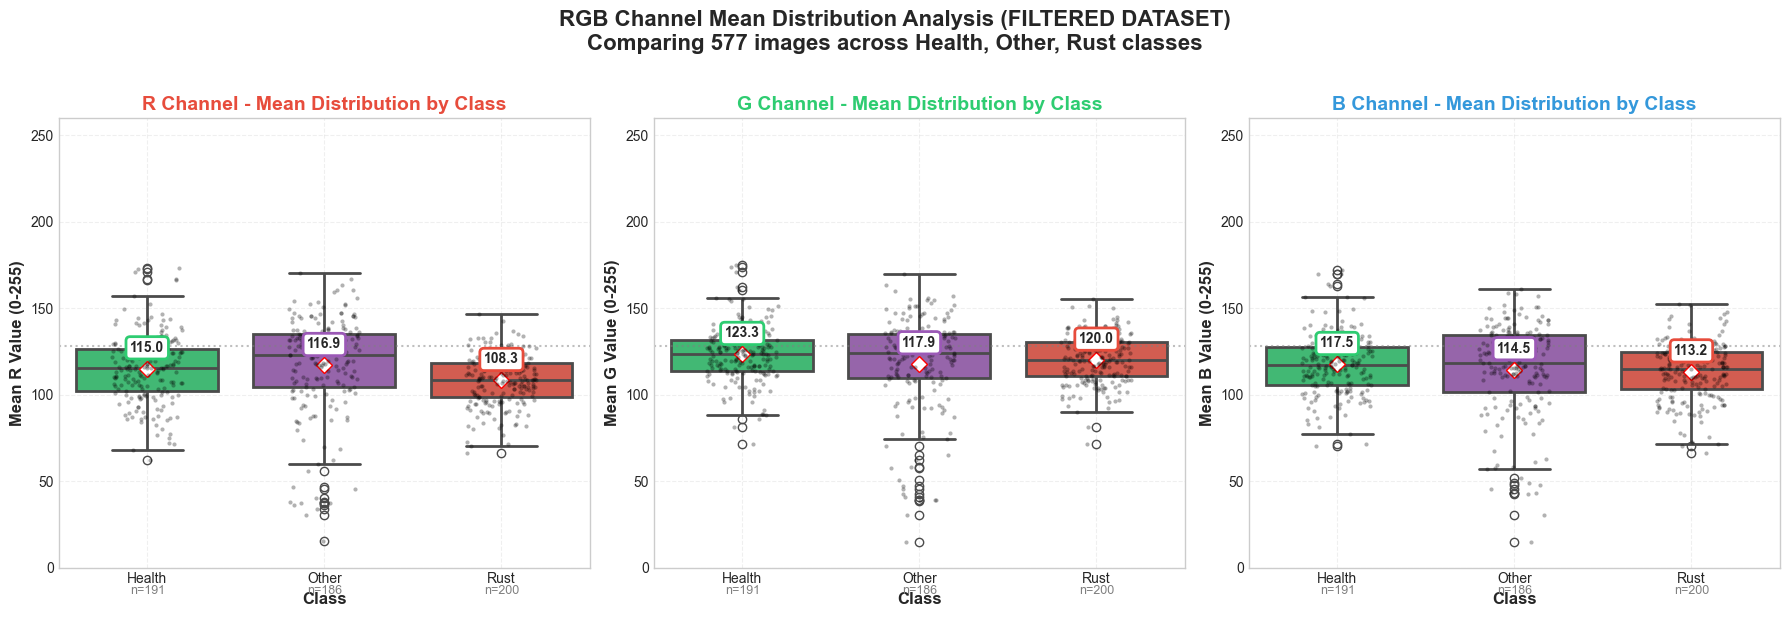

✅ Saved: rgb_boxplot_channel_means_by_class.png


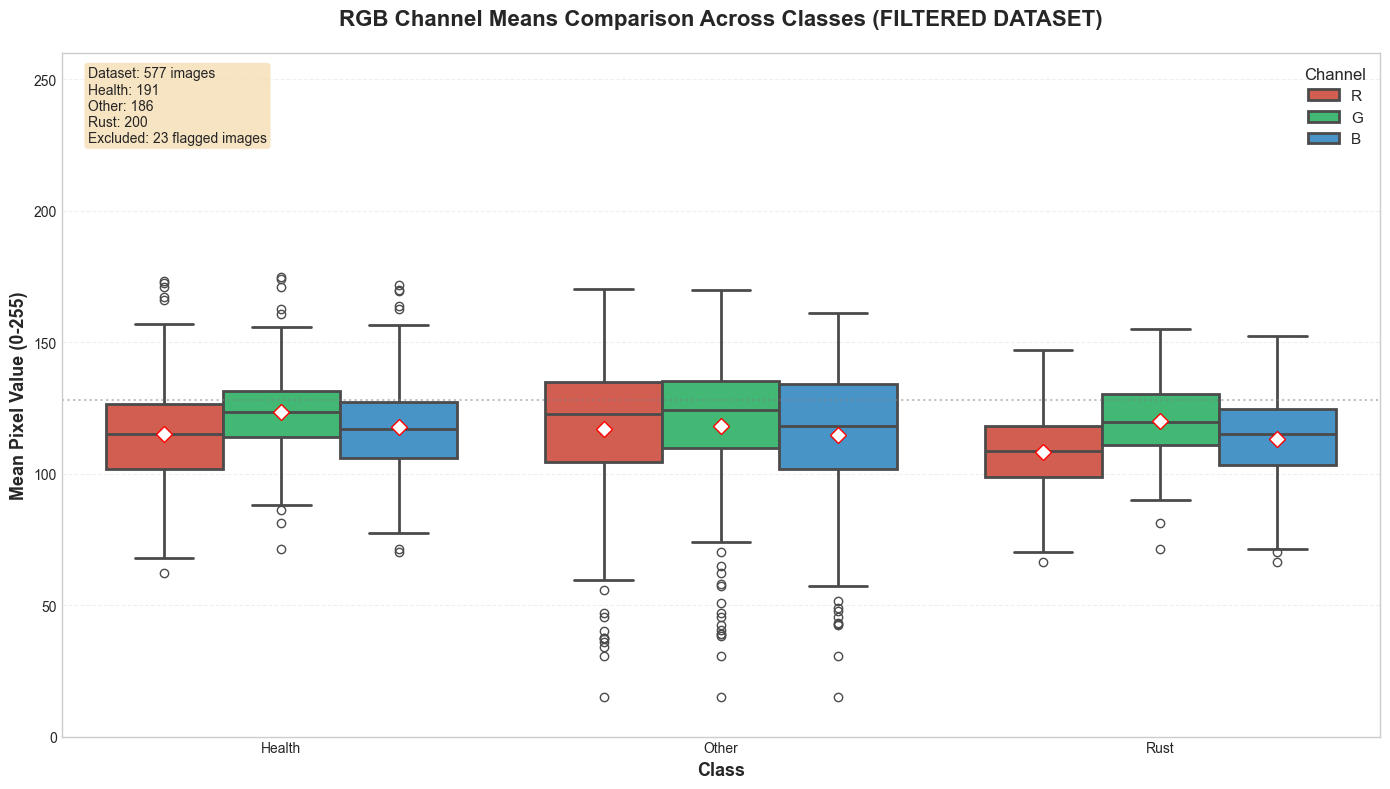

✅ Saved: rgb_boxplot_grouped_comparison.png


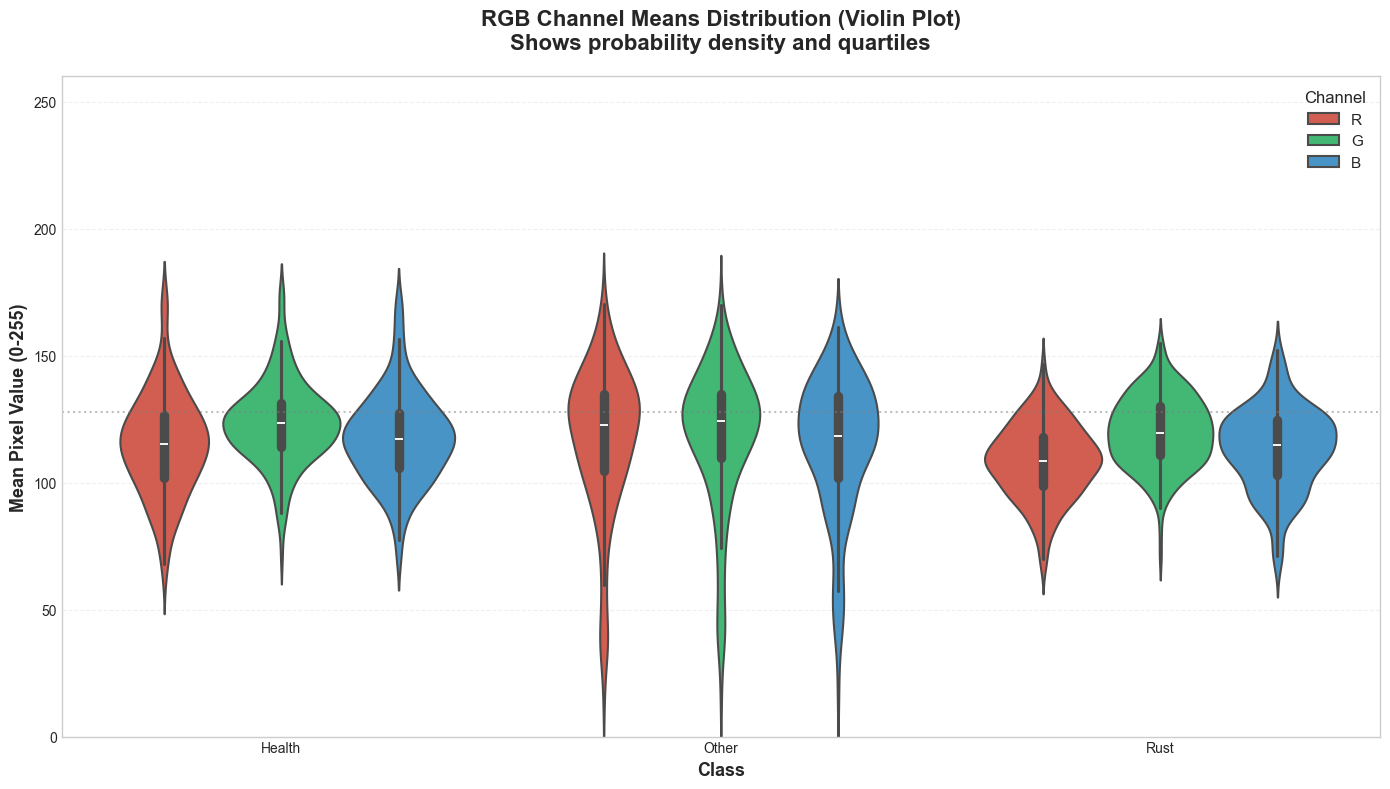

✅ Saved: rgb_violinplot_channel_means.png

🔬 POST-HOC PAIRWISE COMPARISONS (Tukey HSD)

R Channel:
----------------------------------------
  Health     vs Other     :
    Mean difference:    1.94
    p-value:         6.6195e-01  ❌ NOT significant
  Health     vs Rust      :
    Mean difference:    6.71
    p-value:         6.7370e-03  ✅ SIGNIFICANT
  Other      vs Rust      :
    Mean difference:    8.65
    p-value:         3.0897e-04  ✅ SIGNIFICANT

G Channel:
----------------------------------------
  Health     vs Other     :
    Mean difference:    5.40
    p-value:         2.5473e-02  ✅ SIGNIFICANT
  Health     vs Rust      :
    Mean difference:    3.30
    p-value:         2.3721e-01  ❌ NOT significant
  Other      vs Rust      :
    Mean difference:    2.10
    p-value:         5.6204e-01  ❌ NOT significant

B Channel:
----------------------------------------
  Health     vs Other     :
    Mean difference:    3.03
    p-value:         3.3609e-01  ❌ NOT significant
  Health  

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy import stats

# ========= CONFIG =========
TRAIN_RGB_DIR = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB"
CLASSES = ["Health", "Other", "Rust"]
SEED = 42

# ========= BLACKLIST =========
BLACKLIST_FILES = {
    "Health_hyper_12.png",
    "Health_hyper_153.png",
    "Health_hyper_167.png",
    "Health_hyper_23.png",
    "Health_hyper_26.png",
    "Health_hyper_34.png",
    "Health_hyper_38.png",
    "Health_hyper_67.png",
    "Health_hyper_76.png",
    "Other_hyper_102.png",
    "Other_hyper_113.png",
    "Other_hyper_121.png",
    "Other_hyper_122.png",
    "Other_hyper_149.png",
    "Other_hyper_155.png",
    "Other_hyper_160.png",
    "Other_hyper_163.png",
    "Other_hyper_174.png",
    "Other_hyper_22.png",
    "Other_hyper_26.png",
	 "Other_hyper_31.png",
	 "Other_hyper_50.png",
	 "Other_hyper_64.png",

}

# ========= STEP 1: COMPUTE PER-IMAGE CHANNEL MEANS =========
print("🔬 Computing per-image RGB channel means...")

def compute_image_channel_means(img_path):
    """Compute mean of R, G, B channels for a single image."""
    try:
        img = Image.open(img_path).convert("RGB")
        arr = np.array(img, dtype=np.float32)  # (H, W, 3)
        
        means = {
            'R_mean': arr[:, :, 0].mean(),
            'G_mean': arr[:, :, 1].mean(),
            'B_mean': arr[:, :, 2].mean()
        }
        return means
    except Exception as e:
        print(f"⚠️ Error reading {img_path}: {e}")
        return None

# Scan all images
files = sorted([f for f in os.listdir(TRAIN_RGB_DIR) if f.lower().endswith(".png")])
files_clean = [f for f in files if f not in BLACKLIST_FILES]

print(f"📊 Processing {len(files_clean)} images (excluded {len(BLACKLIST_FILES)} flagged)...")

rows = []
for fname in files_clean:
    fpath = os.path.join(TRAIN_RGB_DIR, fname)
    
    # Extract class label
    class_label = fname.split("_")[0]
    if class_label not in CLASSES:
        continue
    
    # Compute channel means
    means = compute_image_channel_means(fpath)
    if means is None:
        continue
    
    rows.append({
        'filename': fname,
        'class': class_label,
        'R_mean': means['R_mean'],
        'G_mean': means['G_mean'],
        'B_mean': means['B_mean']
    })

df_means = pd.DataFrame(rows)
print(f"✅ Computed means for {len(df_means)} images")
print(f"   - Health: {len(df_means[df_means['class']=='Health'])} images")
print(f"   - Other:  {len(df_means[df_means['class']=='Other'])} images")
print(f"   - Rust:   {len(df_means[df_means['class']=='Rust'])} images")

# Save to CSV
df_means.to_csv("rgb_channel_means_per_image.csv", index=False, encoding='utf-8-sig')
print("\n💾 Saved: rgb_channel_means_per_image.csv")

# ========= STEP 2: RESHAPE FOR BOXPLOT =========
# Melt DataFrame để có format: class | channel | value
df_melted = df_means.melt(
    id_vars=['filename', 'class'],
    value_vars=['R_mean', 'G_mean', 'B_mean'],
    var_name='channel',
    value_name='mean_value'
)

# Clean channel names
df_melted['channel'] = df_melted['channel'].str.replace('_mean', '')

# ========= STEP 3: STATISTICAL SUMMARY =========
print("\n" + "=" * 80)
print("📊 STATISTICAL SUMMARY: RGB CHANNEL MEANS BY CLASS")
print("=" * 80)

summary_stats = df_means.groupby('class')[['R_mean', 'G_mean', 'B_mean']].agg([
    'mean', 'std', 'median', 'min', 'max',
    ('Q1', lambda x: np.percentile(x, 25)),
    ('Q3', lambda x: np.percentile(x, 75))
]).round(2)

display(summary_stats)

# ========= STEP 4: ANOVA TESTS =========
print("\n" + "=" * 80)
print("📈 STATISTICAL SIGNIFICANCE TESTS (ANOVA)")
print("=" * 80)

for ch in ['R_mean', 'G_mean', 'B_mean']:
    groups = [df_means[df_means['class'] == c][ch].values for c in CLASSES]
    f_stat, p_value = stats.f_oneway(*groups)
    
    print(f"\n{ch.replace('_mean', '')} Channel:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value:     {p_value:.2e}")
    print(f"  Result:      {'✅ Statistically SIGNIFICANT (p < 0.001)' if p_value < 0.001 else '❌ NOT significant'}")

# ========= STEP 5: PROFESSIONAL BOXPLOT VISUALIZATION =========
print("\n📊 Generating boxplot visualizations...")

# Define color palettes
channel_colors = {"R": "#E74C3C", "G": "#2ECC71", "B": "#3498DB"}
class_colors = {"Health": "#2ECC71", "Other": "#9B59B6", "Rust": "#E74C3C"}

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

# ========= FIGURE 1: SIDE-BY-SIDE BOXPLOTS (3 CHANNELS) =========
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ch in enumerate(['R', 'G', 'B']):
    ax = axes[i]
    
    # Filter data for this channel
    df_ch = df_melted[df_melted['channel'] == ch]
    
    # Create boxplot
    bp = sns.boxplot(
        data=df_ch,
        x='class',
        y='mean_value',
        ax=ax,
        palette=class_colors,
        linewidth=2,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='white', markeredgecolor='red', markersize=8)
    )
    
    # Add individual points (swarmplot) with jitter
    sns.stripplot(
        data=df_ch,
        x='class',
        y='mean_value',
        ax=ax,
        color='black',
        alpha=0.3,
        size=3,
        jitter=0.2
    )
    
    # Styling
    ax.set_title(f'{ch} Channel - Mean Distribution by Class', 
                 fontsize=14, fontweight='bold', color=channel_colors[ch])
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Mean {ch} Value (0-255)', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 260)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add horizontal reference line at 128 (mid-value)
    ax.axhline(128, color='gray', linestyle=':', linewidth=1.5, alpha=0.5, label='Mid (128)')
    
    # Add mean values as text annotations
    for j, cls in enumerate(CLASSES):
        mean_val = df_ch[df_ch['class'] == cls]['mean_value'].mean()
        ax.text(j, mean_val + 8, f'{mean_val:.1f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=class_colors[cls], linewidth=2))
    
    # Add sample size info
    for j, cls in enumerate(CLASSES):
        n = len(df_ch[df_ch['class'] == cls])
        ax.text(j, -15, f'n={n}', ha='center', fontsize=9, color='gray')

plt.suptitle('RGB Channel Mean Distribution Analysis (FILTERED DATASET)\n'
             f'Comparing {len(files_clean)} images across Health, Other, Rust classes',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('rgb_boxplot_channel_means_by_class.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: rgb_boxplot_channel_means_by_class.png")

# ========= FIGURE 2: GROUPED BOXPLOT (ALL CHANNELS TOGETHER) =========
fig, ax = plt.subplots(figsize=(14, 8))

# Create grouped boxplot
bp = sns.boxplot(
    data=df_melted,
    x='class',
    y='mean_value',
    hue='channel',
    ax=ax,
    palette=channel_colors,
    linewidth=2,
    showmeans=True,
    meanprops=dict(marker='D', markerfacecolor='white', markeredgecolor='red', markersize=8)
)

# Styling
ax.set_title('RGB Channel Means Comparison Across Classes (FILTERED DATASET)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Class', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Pixel Value (0-255)', fontsize=13, fontweight='bold')
ax.set_ylim(0, 260)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.axhline(128, color='gray', linestyle=':', linewidth=1.5, alpha=0.5, label='Mid (128)')

# Legend styling
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3], labels[:3], title='Channel', loc='upper right', 
          framealpha=0.95, fontsize=11, title_fontsize=12)

# Add text box with summary statistics
summary_text = f"Dataset: {len(files_clean)} images\n"
summary_text += f"Health: {len(df_means[df_means['class']=='Health'])}\n"
summary_text += f"Other: {len(df_means[df_means['class']=='Other'])}\n"
summary_text += f"Rust: {len(df_means[df_means['class']=='Rust'])}\n"
summary_text += f"Excluded: {len(BLACKLIST_FILES)} flagged images"

ax.text(0.02, 0.98, summary_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('rgb_boxplot_grouped_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: rgb_boxplot_grouped_comparison.png")

# ========= FIGURE 3: VIOLIN PLOT (ALTERNATIVE VISUALIZATION) =========
fig, ax = plt.subplots(figsize=(14, 8))

# Create violin plot
vp = sns.violinplot(
    data=df_melted,
    x='class',
    y='mean_value',
    hue='channel',
    ax=ax,
    palette=channel_colors,
    split=False,
    inner='box',
    linewidth=1.5
)

# Styling
ax.set_title('RGB Channel Means Distribution (Violin Plot)\n'
             'Shows probability density and quartiles',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Class', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Pixel Value (0-255)', fontsize=13, fontweight='bold')
ax.set_ylim(0, 260)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.axhline(128, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3], labels[:3], title='Channel', loc='upper right',
          framealpha=0.95, fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.savefig('rgb_violinplot_channel_means.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: rgb_violinplot_channel_means.png")

# ========= STEP 6: PAIR-WISE COMPARISON (POST-HOC TESTS) - FIXED =========
print("\n" + "=" * 80)
print("🔬 POST-HOC PAIRWISE COMPARISONS (Tukey HSD)")
print("=" * 80)

from scipy.stats import tukey_hsd

for ch in ['R_mean', 'G_mean', 'B_mean']:
    print(f"\n{ch.replace('_mean', '')} Channel:")
    print("-" * 40)
    
    # Prepare data for Tukey HSD
    health_vals = df_means[df_means['class'] == 'Health'][ch].values
    other_vals = df_means[df_means['class'] == 'Other'][ch].values
    rust_vals = df_means[df_means['class'] == 'Rust'][ch].values
    
    # Perform Tukey HSD test
    res = tukey_hsd(health_vals, other_vals, rust_vals)
    
    # ⬅️ FIX: Correct indexing for pairwise p-values
    # Matrix indices: (0,1), (0,2), (1,2) cho 3 groups
    comparisons = [
        ('Health', 'Other', 0, 1),      # res.pvalue[0, 1]
        ('Health', 'Rust', 0, 2),       # res.pvalue[0, 2]
        ('Other', 'Rust', 1, 2)         # res.pvalue[1, 2]
    ]
    
    for c1, c2, i, j in comparisons:
        p_val = res.pvalue[i, j]  # ✅ CORRECT: Upper triangular matrix
        mean_diff = abs(df_means[df_means['class']==c1][ch].mean() - 
                       df_means[df_means['class']==c2][ch].mean())
        
        sig = "✅ SIGNIFICANT" if p_val < 0.05 else "❌ NOT significant"
        print(f"  {c1:10s} vs {c2:10s}:")
        print(f"    Mean difference: {mean_diff:7.2f}")
        print(f"    p-value:         {p_val:10.4e}  {sig}")

# ========= FINAL SUMMARY =========
print("\n" + "=" * 80)
print("✅ ANALYSIS COMPLETE!")
print("=" * 80)
print("\n📁 Generated files:")
print("   1. rgb_channel_means_per_image.csv")
print("   2. rgb_boxplot_channel_means_by_class.png")
print("   3. rgb_boxplot_grouped_comparison.png")
print("   4. rgb_violinplot_channel_means.png")
print("\n🎯 Key Insights:")
print("   - Boxplots show distribution of mean RGB values per image")
print("   - Diamond markers (♦) indicate mean values")
print("   - Individual dots show actual data points")
print("   - Statistical tests confirm significance of class differences")
print("=" * 80)

## 2. MS

Ảnh đó là ảnh gì? Người ta tạo như thế nào?
Có cách nào xem ảnh đó, ý nghĩa nó như thế nào?
Kích cỡ ảnh như thế nào?
Nó có [algiment] với RGB, HS
Miền giá trị: 0 - 255 như ảnh RGB?
Nó có bao nhiêu kênh?
...

## 3. HS

- Làm thế nào để có thể thu thập ảnh này ? 
- 10 ảnh cho mỗi loại và có 3 loại ảnh RGB, MS, HS?